![image](https://github.com/Lexie88rus/NFL-1st-and-Future/raw/master/assets/image.jpg)

[Photo by Dave Adamson on Unsplash](https://unsplash.com/photos/-nATH0CrkMU)

# NFL Injury Analysis

It is incredible how we can apply data science to different areas of our life. Even in sports, data science can help to make the game safer for the athletes.

The main goal of this analysis is to find out factors, which lead to injury. In particular, find out if the effects that synthetic turf versus natural turf can have on player movements and the factors that may contribute to lower extremity injuries.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import itertools

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# image utils
import PIL
from PIL import Image

# import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

# import machine learning
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler, SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score

/kaggle/input/nfl-playing-surface-analytics/PlayList.csv
/kaggle/input/nfl-playing-surface-analytics/PlayerTrackData.csv
/kaggle/input/nfl-playing-surface-analytics/InjuryRecord.csv
/kaggle/input/nfl-utils/inbox_1095143_81d15e8f085b6d72cd7f13fe6c173195_Screen Shot 2019-11-25 at 10.53.52 AM.png
/kaggle/input/nfl-utils/field.png
/kaggle/input/nfl-utils/motion_data.csv
/kaggle/input/nfl-utils/nfl_coordinates.png


Using TensorFlow backend.


## Load Data

Load the data as pandas dataframes:

In [2]:
play_df = pd.read_csv('../input/nfl-playing-surface-analytics/PlayList.csv')
player_df = pd.read_csv('../input/nfl-playing-surface-analytics/PlayerTrackData.csv')
injury_df = pd.read_csv('../input/nfl-playing-surface-analytics/InjuryRecord.csv')

## Data Exploration

First of all, I would like to perform the initial cleaning and make visualizations to get familiar with the data and generate the ideas for further analysis.

### Play Dataset Exploration

`1` General information:

In [3]:
unique_players = play_df.PlayerKey.nunique()
unique_games = play_df.GameID.nunique()
unique_plays = play_df.PlayKey.nunique()

print('There are {} players in the dataset.'.format(unique_players))
print('There are {} games in the dataset.'.format(unique_games))
print('There are {} plays in the dataset.'.format(unique_plays))

There are 250 players in the dataset.
There are 5712 games in the dataset.
There are 267005 plays in the dataset.


`2` Game exploration:

In [4]:
# create a dataframe with game-level information
game_df = play_df[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']].drop_duplicates().reset_index().drop(columns=['index'])

In [5]:
# https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
def add_value_labels(ax, spacing=5, decimals = 0):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        format_str = "{:." + str(decimals) + "f}"
        label = format_str.format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


def visualize_game_features(game_df, rotation = 90, add_labels = False, figsize=(10,10)):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=figsize)
    grid = plt.GridSpec(4, 3, hspace=0.2, wspace=0.2)
    stadium_ax = fig.add_subplot(grid[0, :2])
    fieldtype_ax = fig.add_subplot(grid[0, 2])
    weather_ax = fig.add_subplot(grid[1, 0:])
    temperature_ax = fig.add_subplot(grid[2, 0:])
    temperature_box_ax = fig.add_subplot(grid[3, 0:])

    stadium_ax.bar(game_df.StadiumType.value_counts().keys(), game_df.StadiumType.value_counts().values, color='#00c2c7')
    stadium_ax.set_title('StadiumType')
    stadium_ax.set_xticklabels(game_df.StadiumType.value_counts().keys(), rotation=rotation)
    
    if add_labels:
        add_value_labels(stadium_ax, spacing=5)

    fieldtype_ax.bar(game_df.FieldType.value_counts().keys(), game_df.FieldType.value_counts().values, color=['#00c2c7', '#ff9e15'])
    fieldtype_ax.set_title('FieldType')
    fieldtype_ax.set_xticklabels(game_df.FieldType.value_counts().keys(), rotation=0)
    
    if add_labels:
        add_value_labels(fieldtype_ax, spacing=5)

    weather_ax.bar(game_df.Weather.value_counts().keys(), game_df.Weather.value_counts().values, color='#00c2c7')
    weather_ax.set_title('Weather')
    weather_ax.set_xticklabels(game_df.Weather.value_counts().keys(), rotation=rotation)
    
    if add_labels:
        add_value_labels(weather_ax, spacing=5)
        
    temperature_ax.hist(game_df.Temperature.astype(int).values, bins=30, range=(0,90))
    temperature_ax.set_xlim(0,110)
    temperature_ax.set_xticks(range(0,110,10))
    temperature_ax.set_xticklabels(range(0,110,10))
    temperature_ax.set_title('Temperature')
    
    temperature_box_ax.boxplot(game_df.Temperature.astype(int).values, vert=False)
    temperature_box_ax.set_xlim(0,110)
    temperature_box_ax.set_xticks(range(0,110,10))
    temperature_box_ax.set_xticklabels(range(0,110,10))
    temperature_box_ax.set_yticklabels(['Temperature'])

    plt.suptitle('Game-Level Exploration', fontsize=16)
    plt.show()

In [6]:
def clean_weather(row):
    cloudy = ['Cloudy 50% change of rain', 'Hazy', 'Cloudy.', 'Overcast', 'Mostly Cloudy',
          'Cloudy, fog started developing in 2nd quarter', 'Partly Cloudy',
          'Mostly cloudy', 'Rain Chance 40%',' Partly cloudy', 'Party Cloudy',
          'Rain likely, temps in low 40s', 'Partly Clouidy', 'Cloudy, 50% change of rain','Mostly Coudy', '10% Chance of Rain',
          'Cloudy, chance of rain', '30% Chance of Rain', 'Cloudy, light snow accumulating 1-3"',
          'cloudy', 'Coudy', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy fog started developing in 2nd quarter', 'Cloudy light snow accumulating 1-3"',
         'Cloudywith periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy 50% change of rain', 'Cloudy and cold',
       'Cloudy and Cool', 'Partly cloudy']
    
    clear = ['Clear, Windy',' Clear to Cloudy', 'Clear, highs to upper 80s',
             'Clear and clear','Partly sunny',
             'Clear, Windy', 'Clear skies', 'Sunny', 'Partly Sunny', 'Mostly Sunny', 'Clear Skies',
             'Sunny Skies', 'Partly clear', 'Fair', 'Sunny, highs to upper 80s', 'Sun & clouds', 'Mostly sunny','Sunny, Windy',
             'Mostly Sunny Skies', 'Clear and Sunny', 'Clear and sunny','Clear to Partly Cloudy', 'Clear Skies',
            'Clear and cold', 'Clear and warm', 'Clear and Cool', 'Sunny and cold', 'Sunny and warm', 'Sunny and clear']
    
    rainy = ['Rainy', 'Scattered Showers', 'Showers', 'Cloudy Rain', 'Light Rain', 'Rain shower', 'Rain likely, temps in low 40s.', 'Cloudy, Rain']
    
    snow = ['Heavy lake effect snow']
    
    indoor = ['Controlled Climate', 'Indoors', 'N/A Indoor', 'N/A (Indoors)']
        
    if row.Weather in cloudy:
        return 'Cloudy'
    
    if row.Weather in indoor:
        return 'Indoor'
    
    if row.Weather in clear:
        return 'Clear'
    
    if row.Weather in rainy:
        return 'Rain'
    
    if row.Weather in snow:
        return 'Snow'
      
    if row.Weather in ['Cloudy.', 'Heat Index 95', 'Cold']:
        return np.nan
    
    return row.Weather

def clean_stadiumtype(row):
    if row.StadiumType in ['Bowl', 'Heinz Field', 'Cloudy']:
        return np.nan
    else:
        return row.StadiumType

def clean_play_df(play_df):
    play_df_cleaned = play_df.copy()
    
    # clean StadiumType
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Oudoor|Outdoors|Ourdoor|Outddors|Outdor|Outside', 'Outdoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Indoors|Indoor, Roof Closed|Indoor, Open Roof', 'Indoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Closed Dome|Domed, closed|Domed, Open|Domed, open|Dome, closed|Domed', 'Dome')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Retr. Roof-Closed|Outdoor Retr Roof-Open|Retr. Roof - Closed|Retr. Roof-Open|Retr. Roof - Open|Retr. Roof Closed', 'Retractable Roof')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace('Open', 'Outdoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned.apply(lambda row: clean_stadiumtype(row), axis=1)
    
    # clean Weather
    play_df_cleaned['Weather'] = play_df_cleaned.apply(lambda row: clean_weather(row), axis=1)
    
    return play_df_cleaned

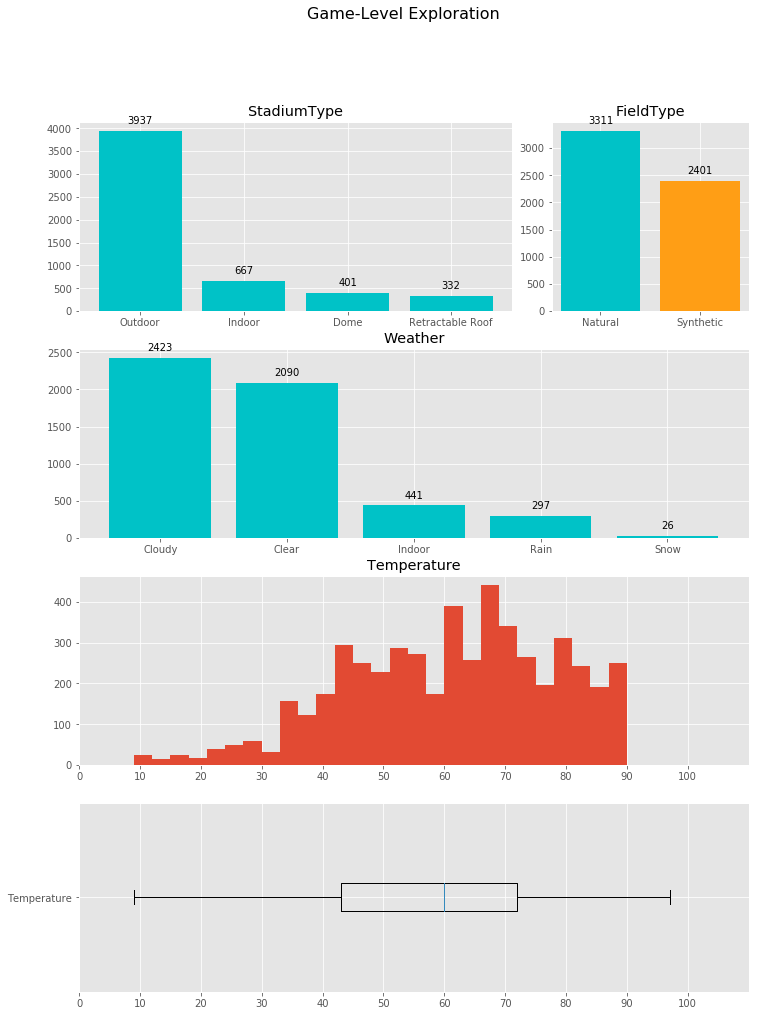

In [7]:
play_df_cleaned = clean_play_df(play_df)
game_df_cleaned = play_df_cleaned[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']].drop_duplicates().reset_index().drop(columns=['index'])
visualize_game_features(game_df_cleaned, rotation=0, add_labels = True, figsize=(12,16))

The diagrams above show:

* __The majority of the games are played outdoors.__ That's why the weather should be important.
* __Synthetic turf is very common, but there are around 30% more games with natural turf.__
* __The temperature and other weather conditions vary greately__. It will be interesting to look at how the temperature affects the injuries.

`3` Player level exploration:

In [8]:
player_data_df = play_df_cleaned[['PlayerKey', 'RosterPosition', 'PlayerGamePlay', 'Position', 'PositionGroup']]

In [9]:
def visualize_player_features(player_df, figsize=(25,20), add_labels=False):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=figsize)
    
    grid = plt.GridSpec(3, 4, hspace=0.2, wspace=0.2)
    
    plays_ax = fig.add_subplot(grid[0, 0:2])
    max_rolling_plays_ax = fig.add_subplot(grid[1, 0:2])
    
    rosterposition_ax = fig.add_subplot(grid[0, 2:])
    positiongroup_ax = fig.add_subplot(grid[1, 2:])
    position_ax = fig.add_subplot(grid[2, 0:])
    
    plays_ax.hist(player_df.groupby(by=['PlayerKey']).count()['RosterPosition'].values, bins=20, color='#00c2c7')
    plays_ax.set_title('Number of plays per player')
    
    max_rolling_plays_ax.hist(player_df.groupby(by=['PlayerKey']).PlayerGamePlay.max().values, bins=20, color='#00c2c7')
    max_rolling_plays_ax.set_title('Maximum number of rolling plays per player')
    
    rosterposition_ax.bar(player_df.RosterPosition.value_counts().keys().values, player_df.RosterPosition.value_counts().values)
    rosterposition_ax.set_xticklabels(player_df.RosterPosition.value_counts().keys().values, rotation=20)
    rosterposition_ax.set_title('Roster Position')
    if add_labels:
        add_value_labels(rosterposition_ax, spacing=5)
    
    position_ax.bar(player_df.Position.value_counts().keys().values, player_df.Position.value_counts().values, color='#ff9e15')
    position_ax.set_title('Position')
    if add_labels:
        add_value_labels(position_ax, spacing=5)
        
    positiongroup_ax.bar(player_df.PositionGroup.value_counts().keys().values, player_df.PositionGroup.value_counts().values)
    positiongroup_ax.set_title('Position Group')
    if add_labels:
        add_value_labels(positiongroup_ax, spacing=5)
    
    plt.suptitle('Player-Level Exploration', fontsize=16)
    plt.show()

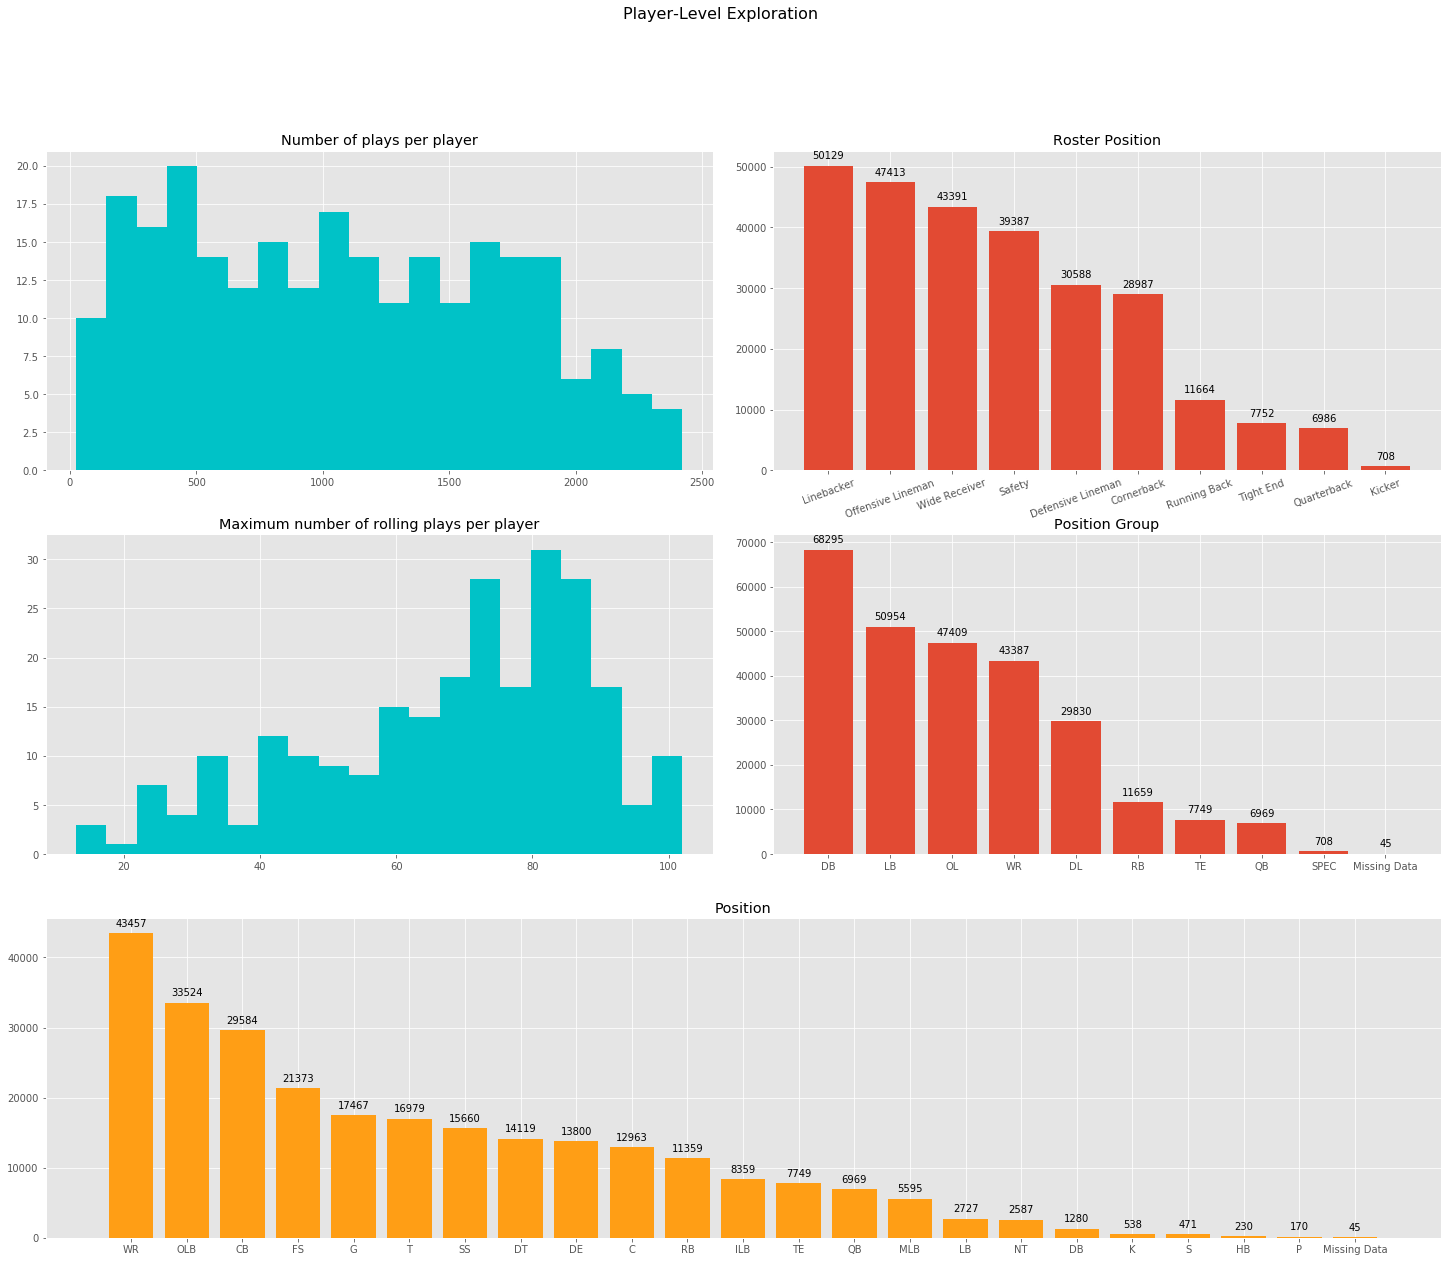

In [10]:
visualize_player_features(player_data_df, add_labels=True)

The diagrams above show that the circumstances around the players vary greatly: some players do much more games than the others, there is a lot of different playing position. All of these factors can contribute to injuries. 

`4` Play-level exploration:

In [11]:
def visualize_play(play_df_cleaned):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    
    plt.bar(play_df_cleaned.PlayType.value_counts().keys().values, play_df_cleaned.PlayType.value_counts().values)
    plt.xticks(range(len(play_df_cleaned.PlayType.value_counts().keys().values)), play_df_cleaned.PlayType.value_counts().keys().values, rotation=20)
    add_value_labels(ax, spacing=5)
    plt.title('Play-Level Exploration: PlayType', fontsize=16)
    
    plt.show()

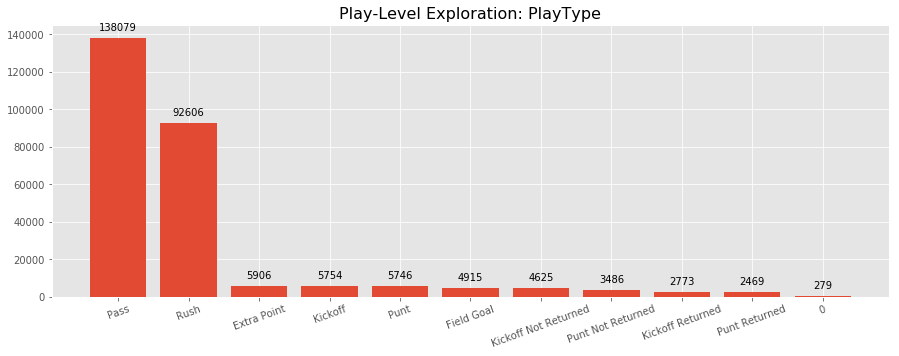

In [12]:
visualize_play(play_df_cleaned)

To my mind, it will be exciting to see how play types affect the injury. I guess that some play types can cause much more dangerous situations than others!

### Player Dataset Visualization and Exploration

`1` Visualize players positions and paths:

To my mind, this is the most exciting part: we can take actual data and track the player's position!

Let's start with visualizing just one line of the dataset:

In [13]:
def get_position(player_df, playkey, time):
    '''
    Helper function to get the player position at a certain time
    '''
    row = player_df[(player_df['PlayKey']==playkey) & (player_df['time']==time)]
    event = row['event'].values[0]
    x = row['x'].values[0]
    y = row['y'].values[0]
    direction = row['dir'].values[0]
    distance = row['dis'].values[0]
    orientation = row['o'].values[0]
    speed = row['s'].values[0]
    
    return event, x, y, direction, distance, orientation, speed
    
def visualize_player_position(player_df, playkey, time, figsize=(24,10)):
    '''
    Helper function to visualize a single player position.
    '''
    
    event, x, y, direction, distance, orientation, speed = get_position(player_df, playkey, time)
    
    background = Image.open('../input/nfl-utils/nfl_coordinates.png')
    background = background.resize((1200,533))
    background = background.transpose(PIL.Image.FLIP_TOP_BOTTOM)
    
    # show background
    fig = plt.figure(figsize=figsize)
    plt.imshow(np.array(background).transpose(0,1,2), origin='lower')
    
    # show orientation
    dx = 5
    dy = dx*np.tan(np.radians(90 + orientation))
    plt.arrow(x*10,y*10,dx,dy, color = '#767676', width=5)
    plt.plot(x*10,y*10,color = '#767676', label='orientation')
    
    # show speed
    dx = speed*20
    dy = dx*np.tan(np.radians(90 + direction))
    plt.arrow(x*10,y*10,dx,dy, color = '#004c97', width=5)
    plt.plot(x*10,y*10, color = '#004c97', label='speed')
    
    # show current player position
    plt.scatter(x*10,y*10,s=200,color='#e01e5a',marker='x')
    plt.annotate('({x:.1f},{y:.1f})'.format(x=x,y=y), (x*10, y*10), xytext=(x*10,y*10-30), color='#e01e5a')
    
    plt.xticks(range(0,1200,100), range(0,120,10))
    plt.yticks(range(0,533,100), range(0,53,10))
    
    plt.title('{play}:{time} {event}'.format(play=playkey, time=time, event = event))
    
    plt.legend()
    plt.show()

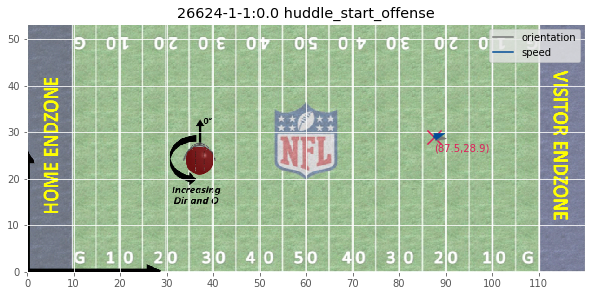

In [14]:
visualize_player_position(player_df, '26624-1-1', 0.0, figsize=(10,5))

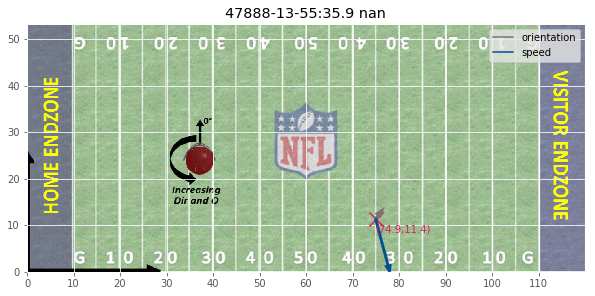

In [15]:
visualize_player_position(player_df, '47888-13-55', 35.9, figsize=(10,5))

We can also plot the entire path of the player during the play and see how he moved:

In [16]:
def visualize_player_track(player_df, playkey, figsize=(24,10), max_positions = 5):
    '''
    Helper function to visualize the whole path of the player
    '''
    # get timestamps per player
    timestamps = player_df[player_df['PlayKey'] == playkey].time.unique()
    
    background = Image.open('../input/nfl-utils/nfl_coordinates.png')
    background = background.resize((1200,533))
    background = background.transpose(PIL.Image.FLIP_TOP_BOTTOM)
    
    # show background
    fig = plt.figure(figsize=figsize)
    plt.imshow(np.array(background).transpose(0,1,2), origin='lower')
    
    # iterate through timestamps
    positions_x, positions_y = [], []
    for i in range(0, len(timestamps), len(timestamps) // max_positions):
        time = timestamps[i]
        # get position and orientation
        event, x, y, direction, distance, orientation, speed = get_position(player_df, playkey, time)
        positions_x.append(x*10)
        positions_y.append(y*10)
        
        # plot orientation and speed for the lasi point
        if (len(timestamps) - i < len(timestamps) // max_positions):
            # show orientation
            dx = 5
            dy = dx*np.tan(np.radians(90 + orientation))
            plt.arrow(x*10,y*10,dx,dy, color = '#767676', width=5)
            plt.plot(x*10,y*10,color = '#767676', label='orientation')

            # show speed
            dx = speed*20
            dy = dx*np.tan(np.radians(90 + direction))
            plt.arrow(x*10,y*10,dx,dy, color = '#004c97', width=5)
            plt.plot(x*10,y*10, color = '#004c97', label='speed')
            
            # add x-marker and annotation only for the last position
            plt.scatter(x*10,y*10,s=200,color='#e01e5a',marker='x')
            plt.annotate('({x:.1f},{y:.1f})'.format(x=x,y=y), (x*10, y*10), xytext=(x*10,y*10-30), color='#e01e5a')
        
    # show player's path
    plt.scatter(positions_x,positions_y,s=50,color='#e01e5a',marker='o')
    plt.plot(positions_x,positions_y,color='#e01e5a', label='player path', linestyle='--')
    
    # creat custom tick labels
    plt.xticks(range(0,1200,100), range(0,120,10))
    plt.yticks(range(0,533,100), range(0,53,10))
    
    # add title
    plt.title('{play}'.format(play=playkey))
    
    plt.legend()
    plt.show()

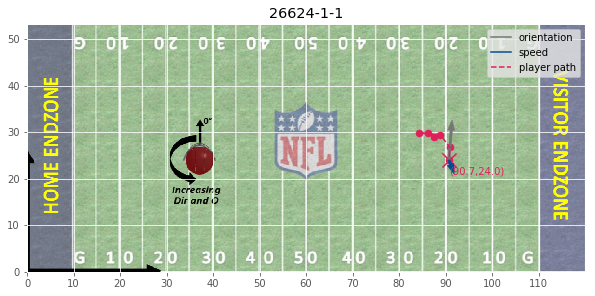

In [17]:
visualize_player_track(player_df, '26624-1-1', max_positions = 5, figsize=(10,5))

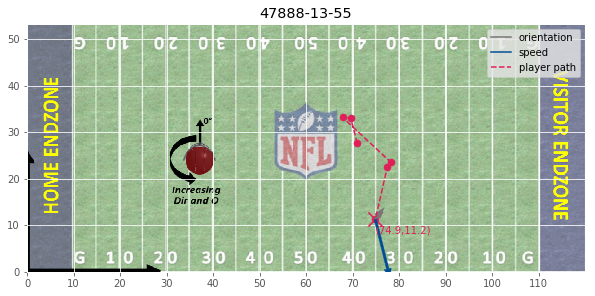

In [18]:
visualize_player_track(player_df, '47888-13-55', max_positions = 5, figsize=(10,5))

`2` Create a heatmap of the field

Let's look at the heatmap of the field:

In [19]:
def visualize_field_heatmap(player_df, xbins=13, ybins=6, annotate = False):
    # create a grid
    x = np.linspace(0, 120, xbins)
    y = np.linspace(0, 53, ybins)
    
    # initialize heatmap
    hmap = np.zeros((xbins,ybins))
    
    for i in range(xbins-1):
        for j in range(ybins-1):
            hmap[i,j] = len(player_df[(player_df.x >= x[i]) & (player_df.x <= x[i+1]) & (player_df.y >= y[j]) & (player_df.y <= y[j+1])])
            
    fig = plt.figure(figsize=(10,5))
    ax = sns.heatmap(np.transpose(hmap), annot=annotate, fmt = '.0f')
    plt.title('Field Heatmap \n the most visited areas of the field are highlighted')
    plt.show()

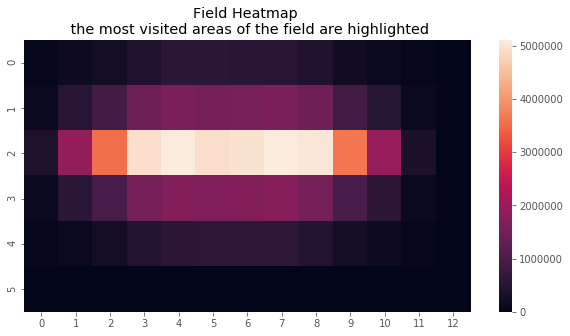

In [20]:
visualize_field_heatmap(player_df)

We can see that some areas of the field are more 'busy' than the others.

### Injuries Dataset EDA

Let's look quickly at the injuries:

In [21]:
print('There are {} injury records in total.'.format(len(injury_df)))

There are 105 injury records in total.


In [22]:
print('{} unique players injured'.format(len(injury_df.PlayerKey.unique())))

100 unique players injured


This means that there are players injured twice!

In [23]:
print('There are {} PlayKey values missing.'.format(len(injury_df) - injury_df.PlayKey.count()))

There are 28 PlayKey values missing.


For around 30% of the injuries, we don't know the play, when the injury took place. It is quite a significant number.

In [24]:
def visualize_injury(injury_df):
    injury_df_cleaned = injury_df.copy()
    injury_df_cleaned.DM_M1 = injury_df_cleaned.DM_M1 - injury_df_cleaned.DM_M7
    injury_df_cleaned.DM_M7 = injury_df_cleaned.DM_M7 - injury_df_cleaned.DM_M28
    injury_df_cleaned.DM_M28 = injury_df_cleaned.DM_M28 - injury_df_cleaned.DM_M42
    
    fig, axs = plt.subplots(1,3, figsize=(15,5))
    
    axs[0].bar(injury_df_cleaned.BodyPart.value_counts().keys().values, injury_df_cleaned.BodyPart.value_counts().values, color='#00c2c7')
    axs[0].set_title('Body Part')
    add_value_labels(axs[0], spacing=5)
    
    axs[1].bar(injury_df_cleaned.Surface.value_counts().keys().values, injury_df_cleaned.Surface.value_counts().values, color='#ff9e15')
    axs[1].set_title('Surface')
    add_value_labels(axs[1], spacing=5)
    
    M1 = injury_df_cleaned.DM_M1.sum()
    M7 = injury_df_cleaned.DM_M7.sum()
    M28 = injury_df_cleaned.DM_M28.sum()
    M42 = injury_df_cleaned.DM_M42.sum()
    
    axs[2].bar(['1-7', '7-28', '28-42', '>=42'], [M1, M7, M28, M42])
    axs[2].set_title('Missed Days')
    add_value_labels(axs[2], spacing=5)
    
    plt.suptitle('Injury', fontsize=16)
    plt.show()

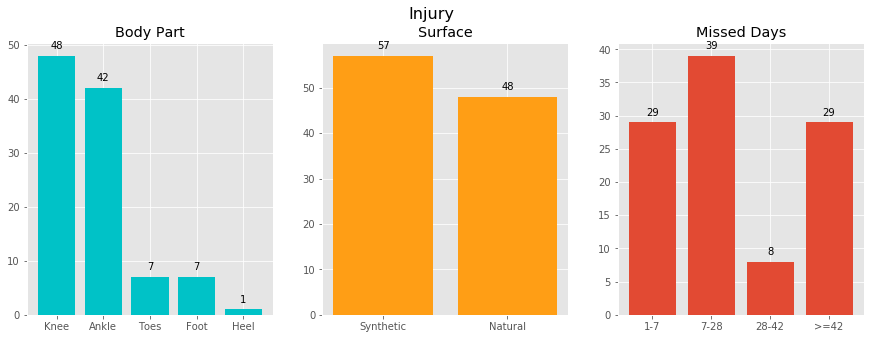

In [25]:
visualize_injury(injury_df)

All in all, we have just **105** injury records! So few!

* We can see that the __knees and ankles are the most frequently injured body parts.__
* We have almost __equal number of observations for synthetic and natural surface.__

## Injury Analysis

`1` Merge injury data with game data (drop the play-level information), so we can explore the dependencies between the injuries and game-level factors.

In [26]:
# joined cleaned games dataset and injury dataset
game_injury_df = injury_df.set_index('GameID').join(game_df_cleaned.set_index('GameID'), how = 'outer')

# fill null values for the injury columns with zeros
game_injury_df['DM_M1'] = game_injury_df['DM_M1'].fillna(0).astype(int)
game_injury_df['DM_M7'] = game_injury_df['DM_M7'].fillna(0).astype(int)
game_injury_df['DM_M28'] = game_injury_df['DM_M28'].fillna(0).astype(int)
game_injury_df['DM_M42'] = game_injury_df['DM_M42'].fillna(0).astype(int)

game_injury_df.DM_M1 = game_injury_df.DM_M1 - game_injury_df.DM_M7
game_injury_df.DM_M7 = game_injury_df.DM_M7 - game_injury_df.DM_M28
game_injury_df.DM_M28 = game_injury_df.DM_M28 - game_injury_df.DM_M42

# introduce a column with a flag indicating an injury
game_injury_df['Injury'] = game_injury_df['DM_M1'] + game_injury_df['DM_M7'] + game_injury_df['DM_M28'] + game_injury_df['DM_M42']

# drop duplicated surface column
game_injury_df = game_injury_df.drop(columns=['Surface'])

# drop play-level features just for now
game_injury_df = game_injury_df.drop(columns=['PlayerKey', 'PlayKey'])

# create dummy variables
game_injury_df_dummies = pd.get_dummies(game_injury_df, dummy_na = True, drop_first = True).drop(columns=['FieldType_nan'])

`2` Now let's visualize the correlations:

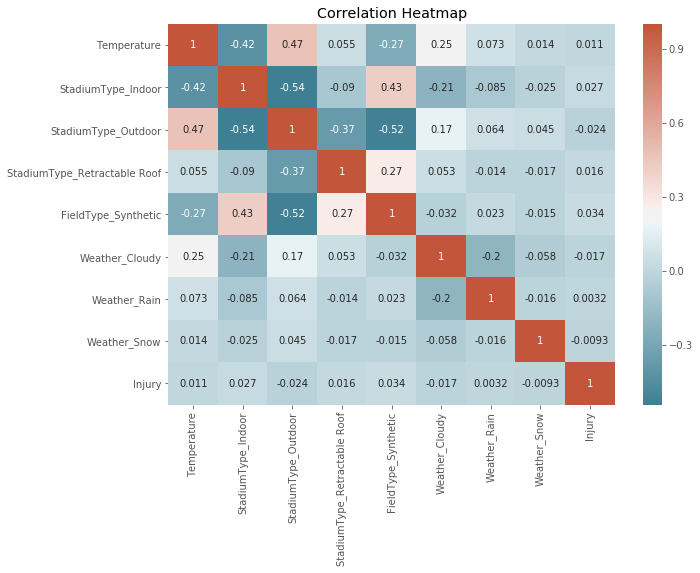

In [27]:
corr_df = game_injury_df_dummies[['Temperature', 'StadiumType_Indoor', 'StadiumType_Outdoor', 'StadiumType_Retractable Roof',
                                 'FieldType_Synthetic', 'Weather_Cloudy', 'Weather_Rain', 'Weather_Snow', 'Injury']].corr()

fig = plt.figure(figsize=(10,7))
sns.heatmap(corr_df, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

Unfortunately, there is __no correlation between our features and the injury.__

Let's look at [Cramer's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V):

In [28]:
# Source:
# https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [29]:
# Source:
# https://stackoverflow.com/questions/51859894/how-to-plot-a-cramer-s-v-heatmap-for-categorical-features
def plot_cramers_v_heatmap(df, cols):
    corrM = np.zeros((len(cols),len(cols)))

    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = cramers_v(pd.crosstab(df[col1], df[col2]).as_matrix())
        corrM[idx2, idx1] = corrM[idx1, idx2]

    corr = pd.DataFrame(corrM, index=cols, columns=cols)
    fig, ax = plt.subplots(figsize=(7, 6))
    ax = sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax); ax.set_title("Cramer V Correlation between Variables");

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


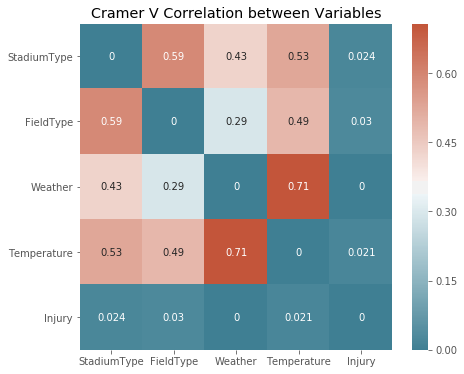

In [30]:
cols = ["StadiumType", "FieldType", "Weather", "Temperature", "Injury"]
plot_cramers_v_heatmap(game_injury_df, cols)

This table looks way more exciting!
* We can see that there are correlations between Weather and Temperature (obviously, snow and rain means lower temperature than sunny weather).
* There is also some correlation between Stadium Type and Temperature.

But unfortunately, still no correlation with the injury.

Let's try [Theil’s U](https://docs.oracle.com/cd/E40248_01/epm.1112/cb_statistical/frameset.htm?ch07s02s03s04.html) to find some insights:

In [31]:
# Source:
# https://github.com/shakedzy/dython/blob/master/dython/nominal.py

from collections import Counter
import math

def conditional_entropy(x, y, nan_strategy='replace', nan_replace_value=0):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    **Returns:** float
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples with missing values, or 'replace'
        to replace all missing values with the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when nan_strategy is set to 'replace'.
    """
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [32]:
def plot_theils_u_heatmap(df, cols):
    corrM = np.zeros((len(cols),len(cols)))

    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = theils_u(df[col1].values, df[col2].values)
        corrM[idx2, idx1] = corrM[idx1, idx2]

    corr = pd.DataFrame(corrM, index=cols, columns=cols)
    fig, ax = plt.subplots(figsize=(7, 6))
    ax = sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax); ax.set_title("Theil's U Correlation between Variables");

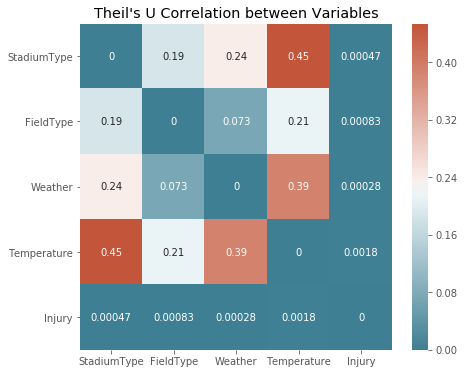

In [33]:
cols = ["StadiumType", "FieldType", "Weather", "Temperature", "Injury"]
plot_theils_u_heatmap(game_injury_df, cols)

Again, no insights on  the injury.

`3` Explore the game features with respect to the injury:

Temperature:

In [34]:
# get the temperature values for games 
# be sure to only take the values where the game was played outdoors
non_injury_temp = game_injury_df[(game_injury_df.StadiumType == 'Outdoor') & (game_injury_df.Temperature >= 0) & (game_injury_df.Injury == 0)].Temperature.values
injury_temp = game_injury_df[(game_injury_df.StadiumType == 'Outdoor') & (game_injury_df.Temperature >= 0) & (game_injury_df.Injury == 1)].Temperature.values

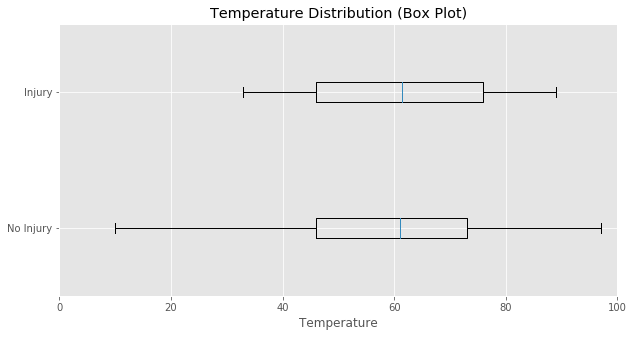

In [35]:
fig = plt.figure(figsize=(10,5))
plt.boxplot([non_injury_temp, injury_temp], vert = False)
plt.title('Temperature Distribution (Box Plot)')
plt.yticks([1,2], ['No Injury', 'Injury'])
plt.xlim(0,100)
plt.xlabel('Temperature')
plt.show()

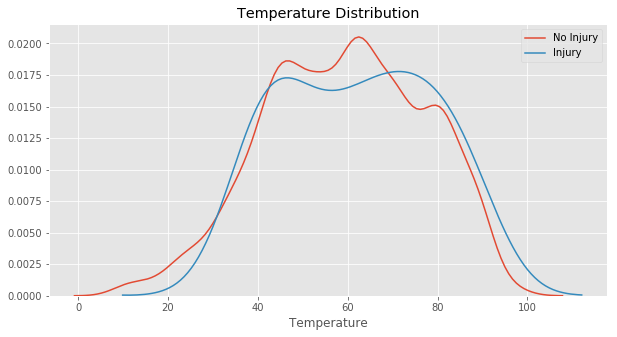

In [36]:
fig, axs = plt.subplots(1,1, figsize=(10,5))
sns.kdeplot(non_injury_temp, label = 'No Injury')
sns.kdeplot(injury_temp, label = 'Injury')
plt.title('Temperature Distribution')
plt.xlabel('Temperature')
plt.show()

Check the Kolmogorov-Smirnov test to check if the temperature samples come from one distribution:

In [37]:
# compare maximum play speed samples
D, pvalue = ss.ks_2samp(non_injury_temp, injury_temp)
D, pvalue

(0.09720742964110508, 0.5698432406774727)

The p-value is high. We can't say that temperature values come from different distributions.

`4` Hypothesis testing

Let's try a simple hypothesis test to check if the number of injuries on synthetic turf is significantly higher. We see that basically, the probability of injury is higher when playing on synthetic turf. But is this statistically significant?

In [38]:
# compute the injury probability for synthetic and natural turf
p_injury = game_injury_df[['FieldType', 'Injury']].groupby('FieldType').mean()['Injury']
p_injury

FieldType
Natural      0.014497
Synthetic    0.023730
Name: Injury, dtype: float64

The null hypothesis is that the probability of the injury on natural turf is less or equal to the probability of the injury on synthetic turf.

In [39]:
# get number of trials and overall injury rate under null
n_natural = game_injury_df[['FieldType', 'Injury']].groupby('FieldType').size()[0]
n_synthetic = game_injury_df[['FieldType', 'Injury']].groupby('FieldType').size()[1]

p_null = game_injury_df[['FieldType', 'Injury']][game_injury_df.FieldType == 'Natural'].mean()[0]

In [40]:
# compute standard error
se_p = np.sqrt(p_null * (1-p_null) * (1/n_natural + 1/n_synthetic))

#  compute z-score and p-value
z = (p_injury[1] - p_injury[0]) / se_p

print('The z-score is: {}'.format(z))
print('The p-value is: {}'.format(1-ss.norm.cdf(z)))

The z-score is: 2.882114721816435
The p-value is: 0.001975079424302306


Under 95% confidence, we reject the null hypothesis if the p-value is less than 0.05. Our computed p-value is approximately 0.002, so we can reject the null hypothesis that the probability of injury on natural turf is less or equal than the injury probability on the synthetic turf. We can conclude that the probability of the injury on synthetic turf is higher than the probability of the injury on natural turf (with 99% confidence).

`5` Play-level features:

In [41]:
# joined cleaned games dataset and injury dataset
play_injury_df = injury_df.dropna(subset=['PlayKey']).set_index('PlayKey').join(play_df_cleaned.set_index('PlayKey'), how = 'outer', lsuffix='_left', rsuffix='_right')

# fill null values for the injury columns with zeros
play_injury_df['DM_M1'] = play_injury_df['DM_M1'].fillna(0).astype(int)
play_injury_df['DM_M7'] = play_injury_df['DM_M7'].fillna(0).astype(int)
play_injury_df['DM_M28'] = play_injury_df['DM_M28'].fillna(0).astype(int)
play_injury_df['DM_M42'] = play_injury_df['DM_M42'].fillna(0).astype(int)

# introduce a column with a flag indicating an injury
play_injury_df.DM_M1 = play_injury_df.DM_M1 - play_injury_df.DM_M7
play_injury_df.DM_M7 = play_injury_df.DM_M7 - play_injury_df.DM_M28
play_injury_df.DM_M28 = play_injury_df.DM_M28 - play_injury_df.DM_M42

play_injury_df['Injury'] = play_injury_df['DM_M1'] + play_injury_df['DM_M7'] + play_injury_df['DM_M28']+ play_injury_df['DM_M42']

# drop duplicated surface column
play_injury_df = play_injury_df.drop(columns=['Surface'])

# create dummy variables
play_injury_df_dummies = pd.get_dummies(play_injury_df, columns = ['PlayType', 'PositionGroup'], dummy_na = True, drop_first = True)

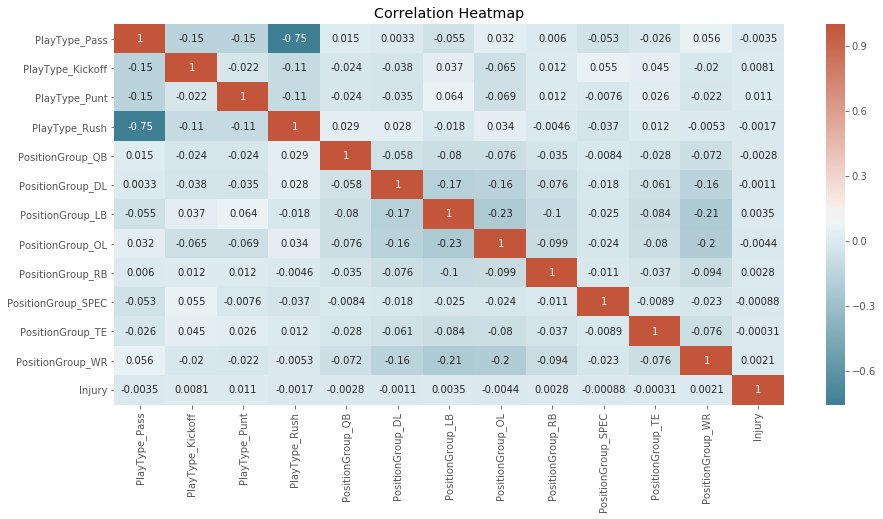

In [42]:
corr_df = play_injury_df_dummies[['PlayType_Pass', 'PlayType_Kickoff', 'PlayType_Punt', 'PlayType_Rush',
                                  'PositionGroup_QB', 'PositionGroup_DL', 'PositionGroup_LB', 'PositionGroup_OL',
                                  'PositionGroup_RB', 'PositionGroup_SPEC', 'PositionGroup_TE', 'PositionGroup_WR',
                                  'Injury']].corr()

fig = plt.figure(figsize=(15,7))
sns.heatmap(corr_df, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

Cramer's V:

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


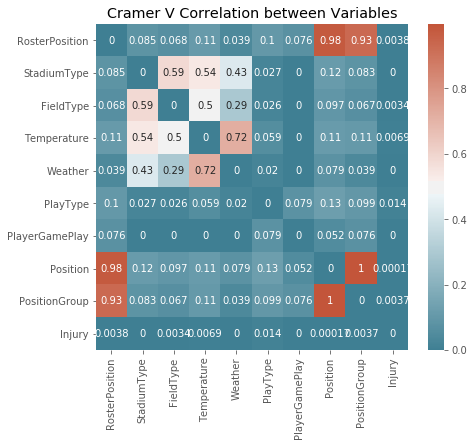

In [43]:
cols = ["RosterPosition", "StadiumType", "FieldType", "Temperature", "Weather", 'PlayType', 'PlayerGamePlay', 'Position', 'PositionGroup', 'Injury']
plot_cramers_v_heatmap(play_injury_df, cols)

Again, this chart shows us some obvious correlations, but still, nothing is correlated with the injury.

Let's tru Theil's U:

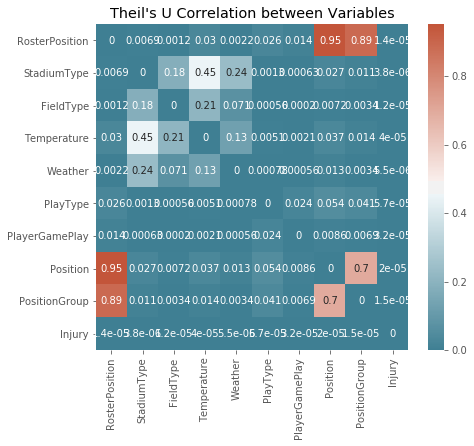

In [44]:
plot_theils_u_heatmap(play_injury_df, cols)

Unfortunately, there are no insights on injury.

Visualize the heatmap of the field with the plays with the injury:

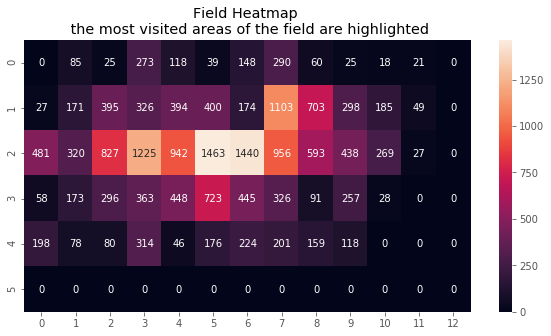

In [45]:
# find the keys of the plays related to injuries
play_injuries = play_injury_df.reset_index().dropna()[['PlayKey']]
# merge the playkeys associated with injuries with players' positions
player_injuries = player_df.merge(play_injuries, on='PlayKey', how='inner') # use inner join!
# visualize the heatmap
visualize_field_heatmap(player_injuries, annotate = True)

It looks like the heatmap of injuries is somewhat different from the general heatmap of the field! Probably, there are more dangerous areas on the field, where players are more likely to get injured!

We can use this insight for the feature engineering for the injury prediction model!

In [46]:
def visualize_field_kde(player_df):
    # plot kde
    fig = plt.figure(figsize=(10,5))
    ax = sns.jointplot(x="x", y="y", data=player_df, kind="kde")
    plt.show()

This is the KDE plot for the injury play locations on the field:

<Figure size 720x360 with 0 Axes>

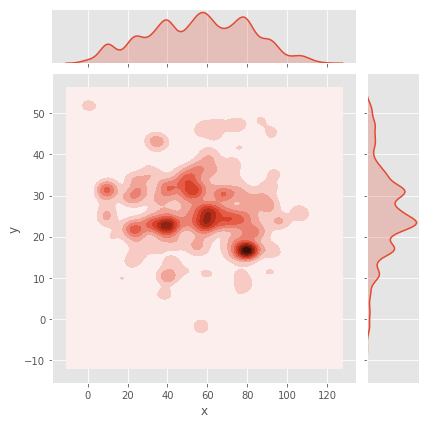

In [47]:
visualize_field_kde(player_injuries)

## Game Timeline and Injury Analysis

Let's plot a timeline of player's games and highlight the days with injuries:

In [48]:
def player_games_timeline(player_key, play_df, injury_df):
    '''
    Function to plot the player's timeline
    '''
    player_games = play_df[play_df.PlayerKey == player_key][['GameID', 'PlayKey', 'PlayerDay', 'PlayerGame']]
    
    # plot timeline for the player
    plt.figure(figsize=(20,5))
    plt.title('Player Games Timeline \n PlayerKey: ' + str(player_key))  
    plt.plot(player_games.PlayerDay.unique(), np.zeros(len(player_games.PlayerDay.unique())), color='#00c2c7')
    plt.scatter(player_games.PlayerDay.unique(), np.zeros(len(player_games.PlayerDay.unique())), s=100, color='#00c2c7', label='games')
    
    # add games with injury
    injured_players = injury_df.PlayerKey.unique()
    if player_key in injured_players:
        injury_games = injury_df[injury_df.PlayerKey == player_key].GameID.values
        injury_days = player_games[player_games.GameID.isin(injury_games)].PlayerDay.unique()
        
        plt.scatter(injury_days, np.zeros(len(injury_days)), s=100, color='#e01e5a', label='injury')
    
    plt.legend()
    plt.xlabel('days')
    plt.yticks([])
    plt.show()

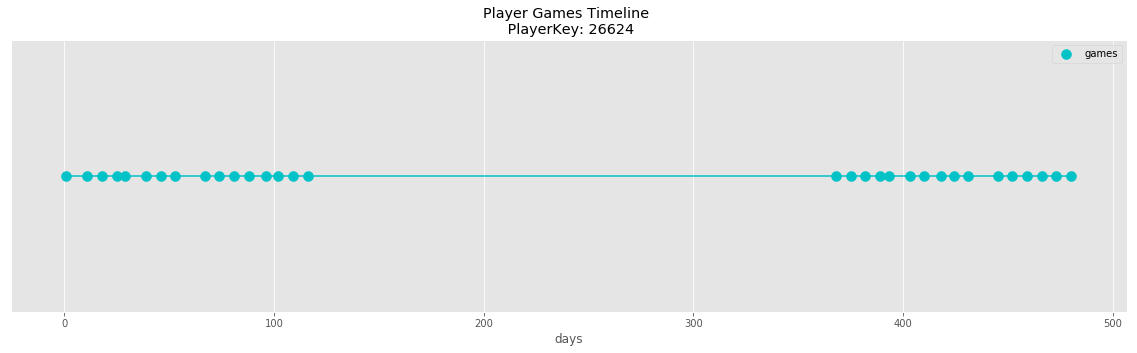

In [49]:
player_games_timeline(26624, play_df, injury_df)

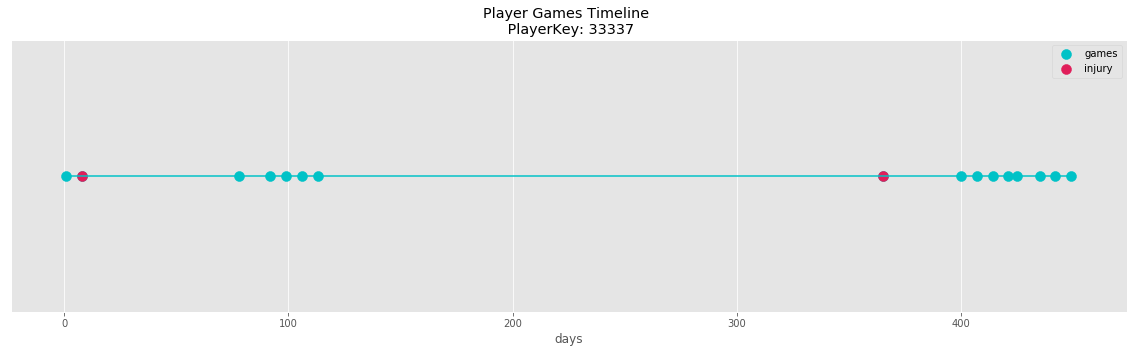

In [50]:
player_games_timeline(33337, play_df, injury_df)

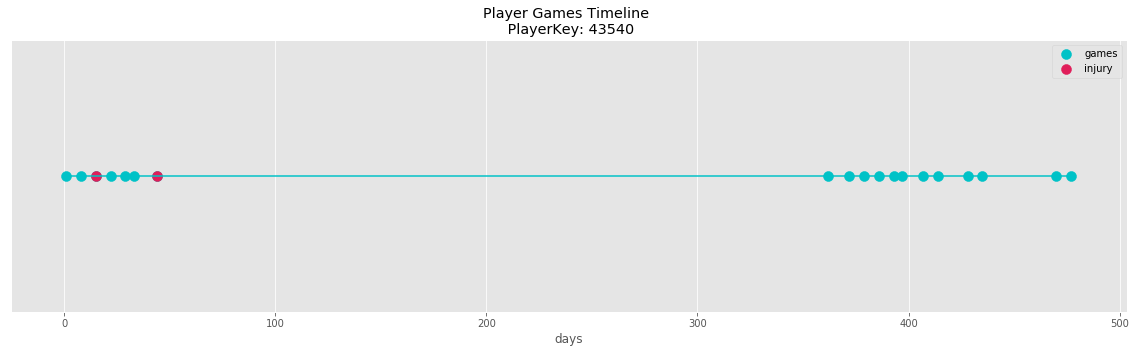

In [51]:
player_games_timeline(43540, play_df, injury_df)

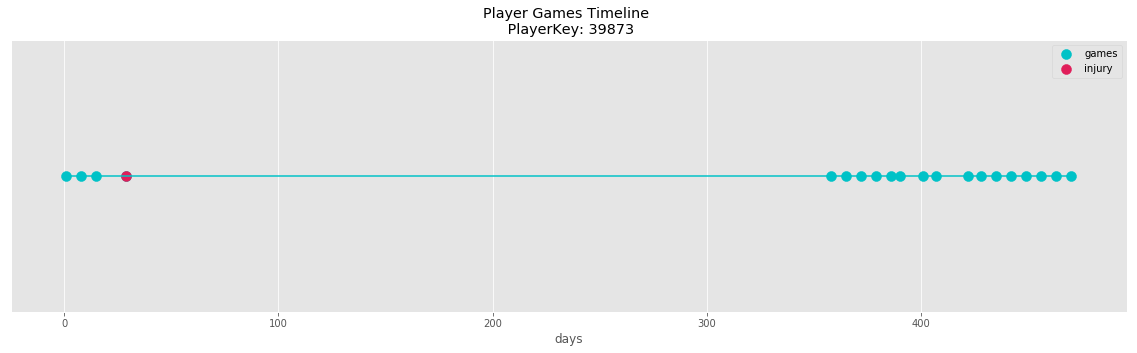

In [52]:
player_games_timeline(39873, play_df, injury_df)

I picked some random injured players from the dataset. It seems that injuries happen at the beginning of the season (for each player).

So is the speed of the player, his position on the field and the number of the game (`PlayerGame`) correlated with the injury?

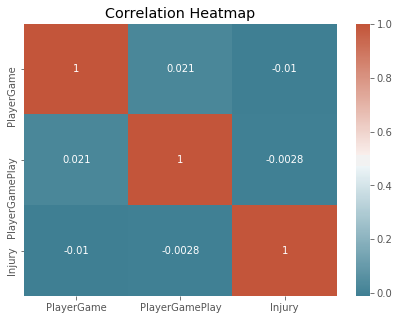

In [53]:
play_injury = play_injury_df[['PlayerGame', 'PlayerGamePlay', 'Injury']]
corrs = play_injury.corr()

fig = plt.figure(figsize=(7,5))
sns.heatmap(corrs, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

The diagram above shows that there is no correlation between the injury and the number of games/plays per game played.

## Data Engineering

My next step is to try to extract features and try to build a model to predict the injury. Hopefully, I will be able to obtain the feature importances out of this model and find out the injury drivers.

In [54]:
# reset index 
features_df = play_injury_df.copy().reset_index()
# drop the irrelevant columns
features_df = features_df.drop(columns=['PlayerKey_left','GameID_left','BodyPart', 'PlayKey', 'PlayerKey_right', 'GameID_right', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42'])
# convert into dummies
features_df = pd.get_dummies(features_df, dummy_na = False, drop_first = True)

## Machine Learning

We have the prepared data, now we can move to the machine learning part.

`1` Split into features and targets:

In [55]:
# split into X and y
y = features_df['Injury']
X = features_df.drop(columns=['Injury'])

`2` Use stratified split to split into train and test set so that class labels will be evenly distributed among the train and the test set:

In [56]:
skf = StratifiedKFold(n_splits=2)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.values[train_index, :], X.values[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

`3` Resampling the dataset:

The number of plays with injury is so tiny that we can't just use the data as-is. Our model will only always predict no injury. That is why we need to resample our dataset. Resampling will help us to generate more examples of cases from the rare class (the injury), so we can train our model! I will use [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/index.html) library.

In [57]:
res = RandomOverSampler(random_state=0)
X_resampled, y_resampled = res.fit_resample(X_train, y_train)

`4` Training the model:

In [58]:
model = xgb.XGBClassifier(max_depth=3,
                      learning_rate=0.1,
                      n_estimators=100,
                      objective='binary:logistic',
                      booster='gbtree',
                      tree_method='auto',
                      n_jobs=50,
                      gamma=0,
                      min_child_weight=1,
                      max_delta_step=0,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      colsample_bynode=1,
                      reg_alpha=0,
                      reg_lambda=1,
                      scale_pos_weight=1,
                      base_score=0.5,
                      random_state=42)
model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=50,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='auto', verbosity=1)

`5` Evaluate the model:

In [59]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
cohen_kappa = cohen_kappa_score(y_test, y_pred)

print('Accuracy: {}'.format(accuracy))
print('Cohen kappa: {}'.format(cohen_kappa))
print('Confusion Matrix: \n {}'.format(conf_matrix))

Accuracy: 0.8947206783418975
Cohen kappa: 0.00014332427129504222
Confusion Matrix: 
 [[119442  14022]
 [    33      5]]


The model's performance is quite poor, but we can still look at the feature importances:

In [60]:
# extract the feature importances from XGBoost model
feature_importances = model.feature_importances_
feature_importances = pd.DataFrame(feature_importances, index = X.columns).reset_index().rename(columns={'index':'feature', 0:'importance'}).sort_values(by=['importance'], ascending=False)

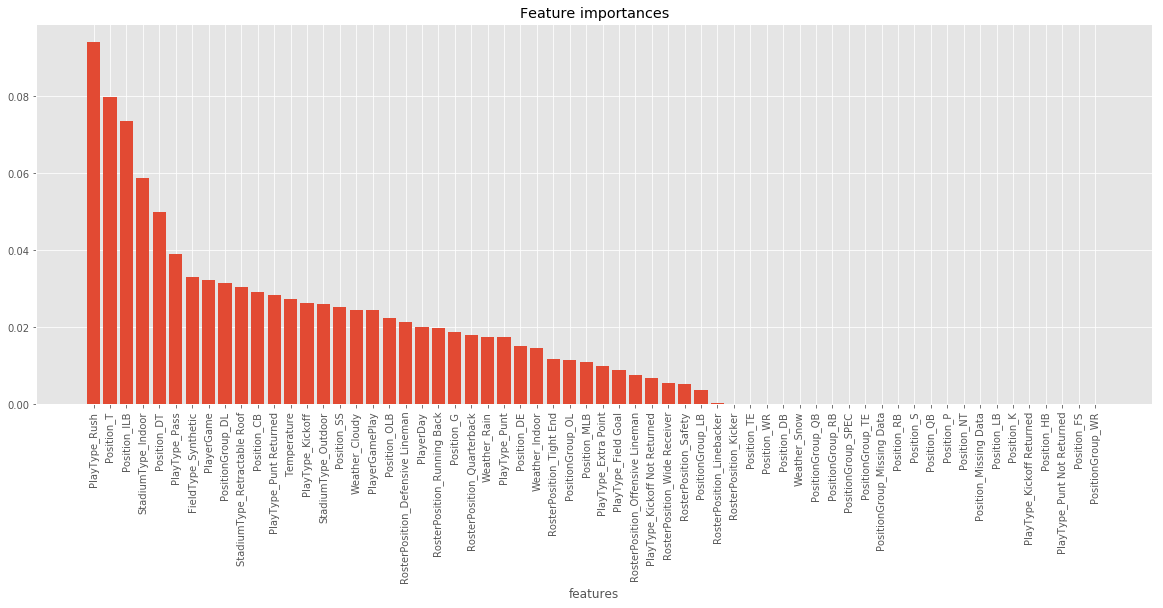

In [61]:
# plot as a bar chart
plt.figure(figsize=(20,7))
plt.bar(range(len(feature_importances)), feature_importances.importance.values)
plt.xticks(range(len(feature_importances)), feature_importances.feature.values, rotation=90)

plt.title('Feature importances')
plt.xlabel('features')
plt.show()

Looking at the chart above, we can say:
* Play type is among features impacting injury;
* Field type feature is also among the important features in our injury predicting model;
* Player game and plyer day are also among the important features impacting the injury.

## Motion Data Analysis

One of the most exciting things in this competition is the analysis of player movements. We can extract a lot of different features for each play, for example:
* the average speed per play (might be calculated out of the coordinates or just the average per play);
* the sharpest turn per play;
* the average angle between the direction and the orientation;
* the maximum angle between the direction and the orientation.

The dataset is too big to process on Kaggle, so I will include my preprocessing code here (see `create_motion_data_df`) and upload the result in the dataset.

In [62]:
def create_motion_data_df(injury_df, play_df, player_df):
    '''
    Function to create aggregated values for motion data.
    '''
    # create a field with the angle between direction and orientation
    player_df['angle'] = player_df['o'] - player_df['dir']
    
    # greate grouped dataframes
    grouped_max = player_df[['PlayKey','time', 'dir', 'dis', 'o', 's', 'angle']].groupby(by=['PlayKey']).max()
    grouped_average = player_df[['PlayKey','time', 'dir', 'dis', 'o', 's', 'angle']].groupby(by=['PlayKey']).mean()
    
    # merge with play data
    play_df = play_df.merge(grouped_max.reset_index(), on=['PlayKey'])
    play_df = play_df.merge(grouped_average.reset_index(), on=['PlayKey'], suffixes=('_max', '_avg'))
    
    # merge with injury data
    injury_df = injury_df.drop(columns=['PlayerKey', 'GameID', 'BodyPart', 'Surface']).merge(play_df, on=['PlayKey'], how='outer').fillna(0)
    
    return injury_df

In [63]:
# load the preprocessed data
motion_df = pd.read_csv('../input/nfl-utils/motion_data.csv').drop(columns=['Unnamed: 0'])
motion_df.head()

PlayKey  DM_M1  DM_M7  DM_M28  DM_M42  PlayerKey   GameID  \
0  39873-4-32    1.0    1.0     1.0     1.0    39873.0  39873-4   
1  46074-7-26    1.0    1.0     0.0     0.0    46074.0  46074-7   
2  36557-1-70    1.0    1.0     1.0     1.0    36557.0  36557-1   
3  46646-3-30    1.0    0.0     0.0     0.0    46646.0  46646-3   
4  43532-5-69    1.0    1.0     1.0     1.0    43532.0  43532-5   

  RosterPosition  PlayerDay  PlayerGame  ... dis_max   o_max  s_max angle_max  \
0     Linebacker       29.0         4.0  ...    0.93  359.47   8.98    329.63   
1     Linebacker       50.0         7.0  ...    0.74  359.26   7.26    280.23   
2         Safety        1.0         1.0  ...    0.64  359.84   5.75    286.47   
3     Linebacker       15.0         3.0  ...    0.76  359.67   7.23    304.71   
4  Wide Receiver       32.0         5.0  ...    0.57  359.98   4.73    331.65   

  time_avg     dir_avg   dis_avg       o_avg     s_avg  angle_avg  
0    22.05  189.061222  0.160837  126.987421  1.489140 -62.073801  
1    11.10  144.081300  0.210269  146.973453  2.024215   2.892152  
2     7.95  156.608562  0.168875   87.116313  1.574938 -69.492250  
3    12.45  126.469440  0.237160  188.707200  2.194320  62.237760  
4    17.45  164.235943  0.087743  160.628057  0.760543  -3.607886  

[5 rows x 30 columns]

In [64]:
# introduce a column with a flag indicating an injury
motion_df.DM_M1 = motion_df.DM_M1 - motion_df.DM_M7
motion_df.DM_M7 = motion_df.DM_M7 - motion_df.DM_M28
motion_df.DM_M28 = motion_df.DM_M28 - motion_df.DM_M42
motion_df['Injury'] = motion_df['DM_M1'] + motion_df['DM_M7'] + motion_df['DM_M28']+ motion_df['DM_M42']

Explore the correlations:

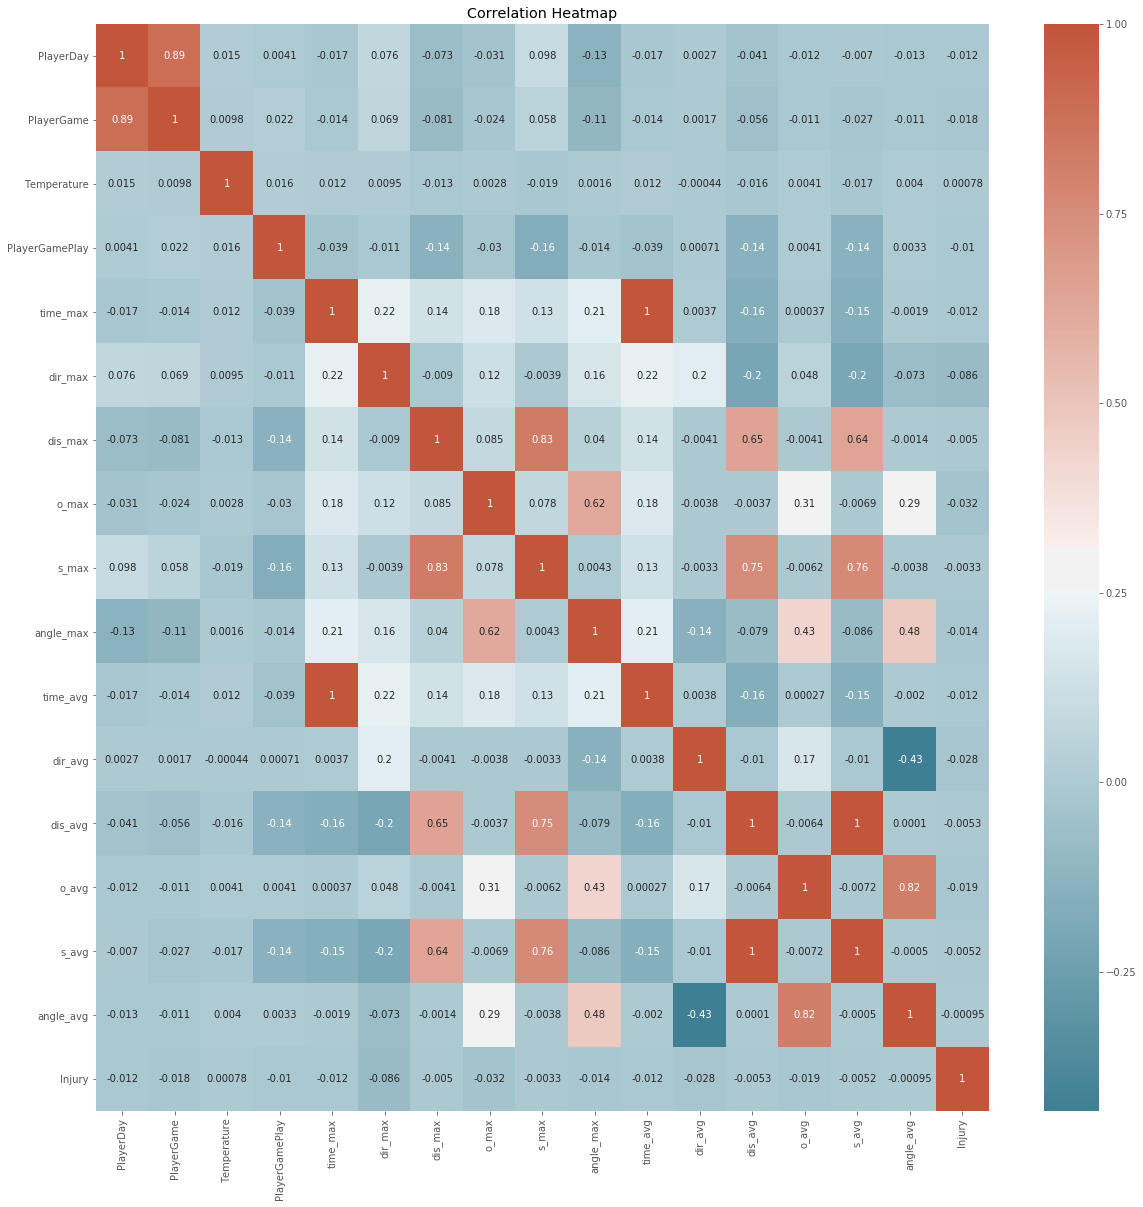

In [65]:
corr_df = motion_df[['RosterPosition', 'PlayerDay', 'PlayerGame', 'StadiumType', 'FieldType',
       'Temperature', 'Weather', 'PlayType', 'PlayerGamePlay', 'Position',
       'PositionGroup', 'time_max', 'dir_max', 'dis_max', 'o_max', 's_max',
       'angle_max', 'time_avg', 'dir_avg', 'dis_avg', 'o_avg', 's_avg',
       'angle_avg', 'Injury']].corr()

fig = plt.figure(figsize=(20,20))
sns.heatmap(corr_df, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

We can see that the distances and speed per play have a negative correlation with PlayerGamePlay. Does it mean that players get tired and move slower?

### Explore Motion for Plays with Injury vs Plays with No Injury

Let's look at the distribution of motion features for plays with injury:

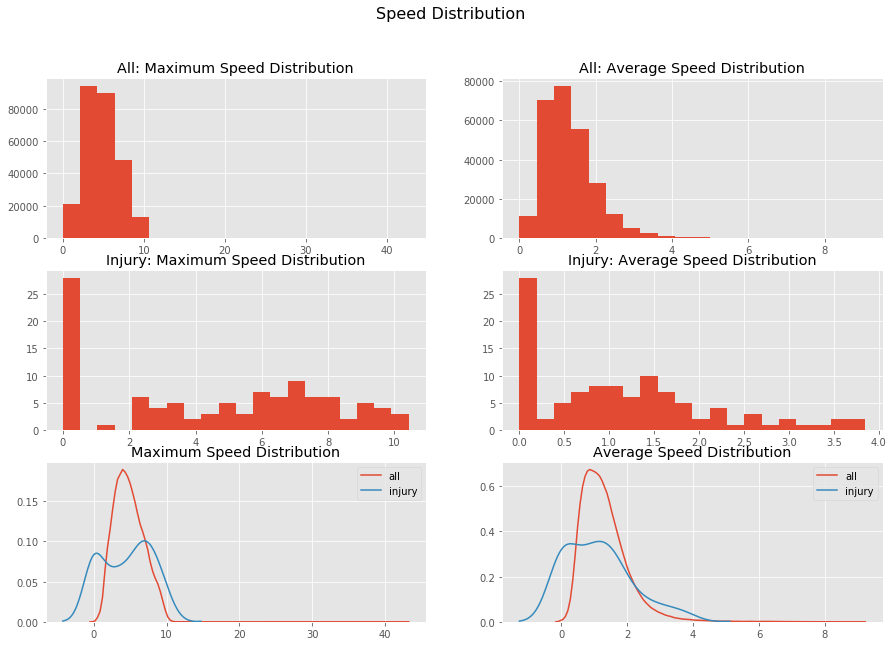

In [66]:
fig, axs = plt.subplots(3,2,figsize=(15,10))

axs[0,0].hist(motion_df.s_max, bins = 20)
axs[0,0].set_title('All: Maximum Speed Distribution')

axs[1,0].hist(motion_df[motion_df.Injury == 1].s_max, bins = 20)
axs[1,0].set_title('Injury: Maximum Speed Distribution')

axs[0,1].hist(motion_df.s_avg, bins = 20)
axs[0,1].set_title('All: Average Speed Distribution')

axs[1,1].hist(motion_df[motion_df.Injury == 1].s_avg, bins = 20)
axs[1,1].set_title('Injury: Average Speed Distribution')

sns.kdeplot(motion_df.s_max, ax = axs[2,0], label='all')
sns.kdeplot(motion_df[motion_df.Injury == 1].s_max,ax = axs[2,0], label='injury')
axs[2,0].set_title('Maximum Speed Distribution')

sns.kdeplot(motion_df.s_avg, ax = axs[2,1], label='all')
sns.kdeplot(motion_df[motion_df.Injury == 1].s_avg,ax = axs[2,1], label='injury')
axs[2,1].set_title('Average Speed Distribution')

plt.suptitle('Speed Distribution', fontsize=16)
plt.show()

It seems that speed for plays with injuries may come from a different distribution. Let's try [Kolmogorov–Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) to check if those samples come from one distribution:

In [67]:
# compare maximum play speed samples
D, pvalue = ss.ks_2samp(motion_df.s_max, motion_df[motion_df.Injury == 1].s_max)
D, pvalue

(0.26627246458700193, 4.6907846557501457e-07)

In [68]:
# compare average play speed samples
D, pvalue = ss.ks_2samp(motion_df.s_avg, motion_df[motion_df.Injury == 1].s_avg)
D, pvalue

(0.2667397212191192, 4.4458735219227083e-07)

The p-value is very small, so we can reject the null hypothesis that both samples are drawn from one distribution. It means that most certainly, we do have some difference between speed for normal plays and plays with the injury.

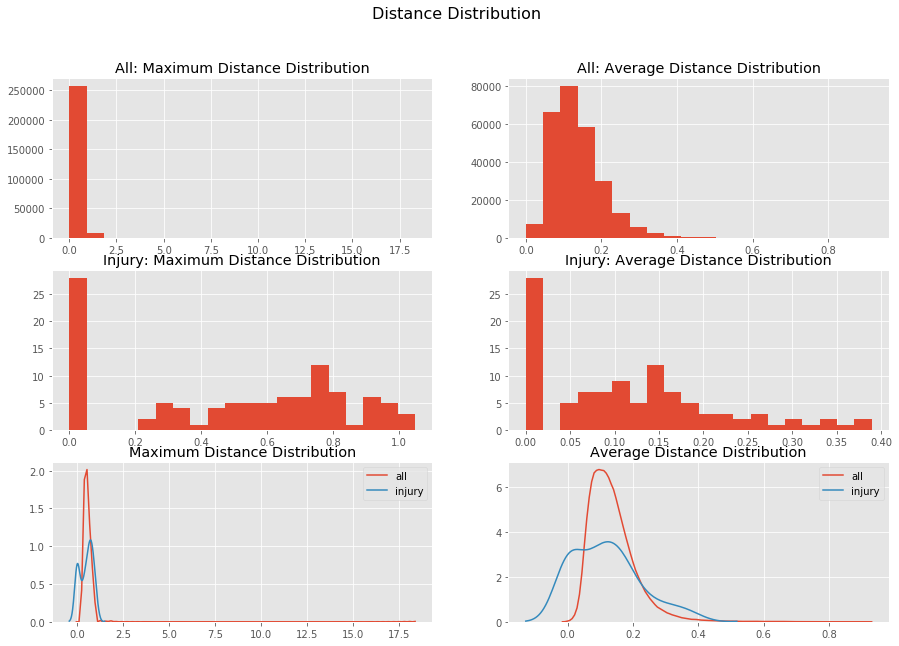

In [69]:
fig, axs = plt.subplots(3,2,figsize=(15,10))

axs[0,0].hist(motion_df.dis_max, bins = 20)
axs[0,0].set_title('All: Maximum Distance Distribution')

axs[1,0].hist(motion_df[motion_df.Injury == 1].dis_max, bins = 20)
axs[1,0].set_title('Injury: Maximum Distance Distribution')

axs[0,1].hist(motion_df.dis_avg, bins = 20)
axs[0,1].set_title('All: Average Distance Distribution')

axs[1,1].hist(motion_df[motion_df.Injury == 1].dis_avg, bins = 20)
axs[1,1].set_title('Injury: Average Distance Distribution')

sns.kdeplot(motion_df.dis_max, ax = axs[2,0], label='all')
sns.kdeplot(motion_df[motion_df.Injury == 1].dis_max,ax = axs[2,0], label='injury')
axs[2,0].set_title('Maximum Distance Distribution')

sns.kdeplot(motion_df.dis_avg, ax = axs[2,1], label='all')
sns.kdeplot(motion_df[motion_df.Injury == 1].dis_avg,ax = axs[2,1], label='injury')
axs[2,1].set_title('Average Distance Distribution')

plt.suptitle('Distance Distribution', fontsize=16)
plt.show()

Apply Kolmogorov-Smirnov test:

In [70]:
# compare maximum play speed samples
D, pvalue = ss.ks_2samp(motion_df.dis_max, motion_df[motion_df.Injury == 1].dis_max)
D, pvalue

(0.2664831385063305, 4.5787867480648906e-07)

In [71]:
# compare maximum play speed samples
D, pvalue = ss.ks_2samp(motion_df.dis_avg, motion_df[motion_df.Injury == 1].dis_avg)
D, pvalue

(0.2664831385063305, 4.5787867480648906e-07)

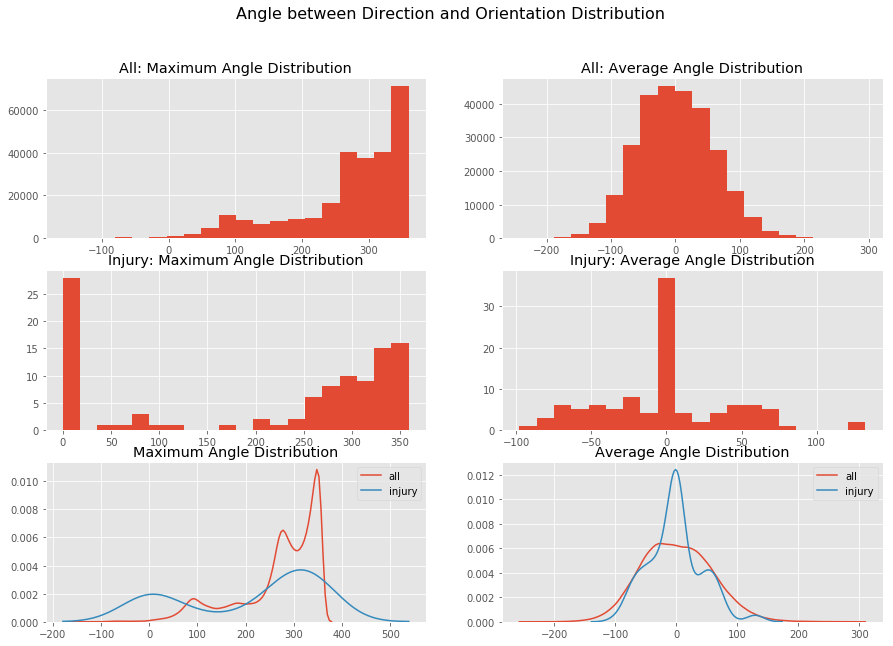

In [72]:
fig, axs = plt.subplots(3,2,figsize=(15,10))

axs[0,0].hist(motion_df.angle_max, bins = 20)
axs[0,0].set_title('All: Maximum Angle Distribution')

axs[1,0].hist(motion_df[motion_df.Injury == 1].angle_max, bins = 20)
axs[1,0].set_title('Injury: Maximum Angle Distribution')

axs[0,1].hist(motion_df.angle_avg, bins = 20)
axs[0,1].set_title('All: Average Angle Distribution')

axs[1,1].hist(motion_df[motion_df.Injury == 1].angle_avg, bins = 20)
axs[1,1].set_title('Injury: Average Angle Distribution')

sns.kdeplot(motion_df.angle_max, ax = axs[2,0], label='all')
sns.kdeplot(motion_df[motion_df.Injury == 1].angle_max,ax = axs[2,0], label='injury')
axs[2,0].set_title('Maximum Angle Distribution')

sns.kdeplot(motion_df.angle_avg, ax = axs[2,1], label='all')
sns.kdeplot(motion_df[motion_df.Injury == 1].angle_avg,ax = axs[2,1], label='injury')
axs[2,1].set_title('Average Angle Distribution')

plt.suptitle('Angle between Direction and Orientation Distribution', fontsize=16)
plt.show()

Kolmogorov-Smirnov test:

In [73]:
# compare maximum play speed samples
D, pvalue = ss.ks_2samp(motion_df.angle_max, motion_df[motion_df.Injury == 1].angle_max)
D, pvalue

(0.26592042582813735, 4.88387320395784e-07)

In [74]:
# compare maximum play speed samples
D, pvalue = ss.ks_2samp(motion_df.angle_avg, motion_df[motion_df.Injury == 1].angle_avg)
D, pvalue

(0.18757487601147826, 0.0010257167928934836)

We can see a little different result here: average angle distribution for all plays and plays with injury are close. We can see that the p-value for these distributions is higher, and the KDE plots look somewhat similar.

In general, the motion features for plays related to injury look different: their distributions have two spikes. One of the peaks is around zero value. Probably, the injury made the player stop for a while. That is why we see speed and distance values concentrated around zero.

### Explore Motion for Plays on Synthetic vs Natural Turf

Explore the speed:

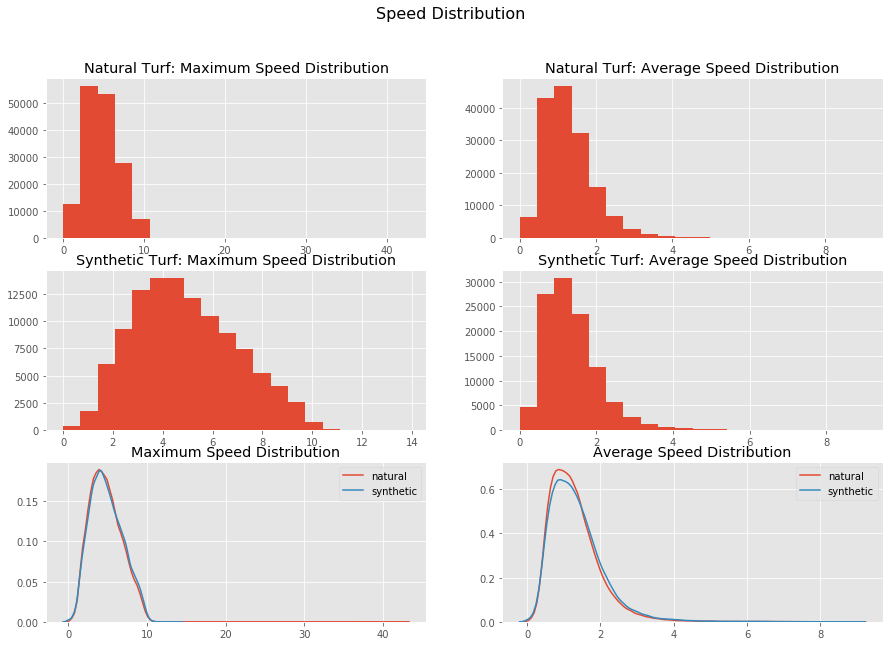

In [75]:
fig, axs = plt.subplots(3,2,figsize=(15,10))

axs[0,0].hist(motion_df[motion_df.FieldType == 'Natural'].s_max, bins = 20)
axs[0,0].set_title('Natural Turf: Maximum Speed Distribution')

axs[1,0].hist(motion_df[motion_df.FieldType == 'Synthetic'].s_max, bins = 20)
axs[1,0].set_title('Synthetic Turf: Maximum Speed Distribution')

axs[0,1].hist(motion_df[motion_df.FieldType =='Natural'].s_avg, bins = 20)
axs[0,1].set_title('Natural Turf: Average Speed Distribution')

axs[1,1].hist(motion_df[motion_df.FieldType == 'Synthetic'].s_avg, bins = 20)
axs[1,1].set_title('Synthetic Turf: Average Speed Distribution')

sns.kdeplot(motion_df[motion_df.FieldType == 'Natural'].s_max, ax = axs[2,0], label='natural')
sns.kdeplot(motion_df[motion_df.FieldType == 'Synthetic'].s_max,ax = axs[2,0], label='synthetic')
axs[2,0].set_title('Maximum Speed Distribution')

sns.kdeplot(motion_df[motion_df.FieldType == 'Natural'].s_avg, ax = axs[2,1], label='natural')
sns.kdeplot(motion_df[motion_df.FieldType == 'Synthetic'].s_avg,ax = axs[2,1], label='synthetic')
axs[2,1].set_title('Average Speed Distribution')

plt.suptitle('Speed Distribution', fontsize=16)
plt.show()

We can see that the speed distribution for the natural and synthetic field type are almost identical!

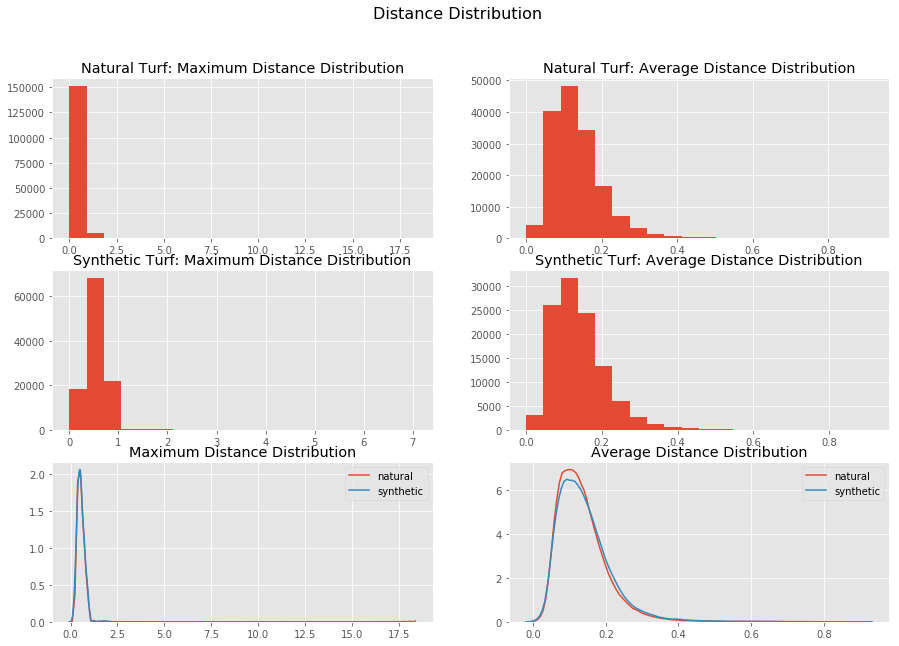

In [76]:
fig, axs = plt.subplots(3,2,figsize=(15,10))

axs[0,0].hist(motion_df[motion_df.FieldType == 'Natural'].dis_max, bins = 20)
axs[0,0].set_title('Natural Turf: Maximum Distance Distribution')

axs[1,0].hist(motion_df[motion_df.FieldType == 'Synthetic'].dis_max, bins = 20)
axs[1,0].set_title('Synthetic Turf: Maximum Distance Distribution')

axs[0,1].hist(motion_df[motion_df.FieldType =='Natural'].dis_avg, bins = 20)
axs[0,1].set_title('Natural Turf: Average Distance Distribution')

axs[1,1].hist(motion_df[motion_df.FieldType == 'Synthetic'].dis_avg, bins = 20)
axs[1,1].set_title('Synthetic Turf: Average Distance Distribution')

sns.kdeplot(motion_df[motion_df.FieldType == 'Natural'].dis_max, ax = axs[2,0], label='natural')
sns.kdeplot(motion_df[motion_df.FieldType == 'Synthetic'].dis_max,ax = axs[2,0], label='synthetic')
axs[2,0].set_title('Maximum Distance Distribution')

sns.kdeplot(motion_df[motion_df.FieldType == 'Natural'].dis_avg, ax = axs[2,1], label='natural')
sns.kdeplot(motion_df[motion_df.FieldType == 'Synthetic'].dis_avg,ax = axs[2,1], label='synthetic')
axs[2,1].set_title('Average Distance Distribution')

plt.suptitle('Distance Distribution', fontsize=16)
plt.show()

The same thing is for the distance.

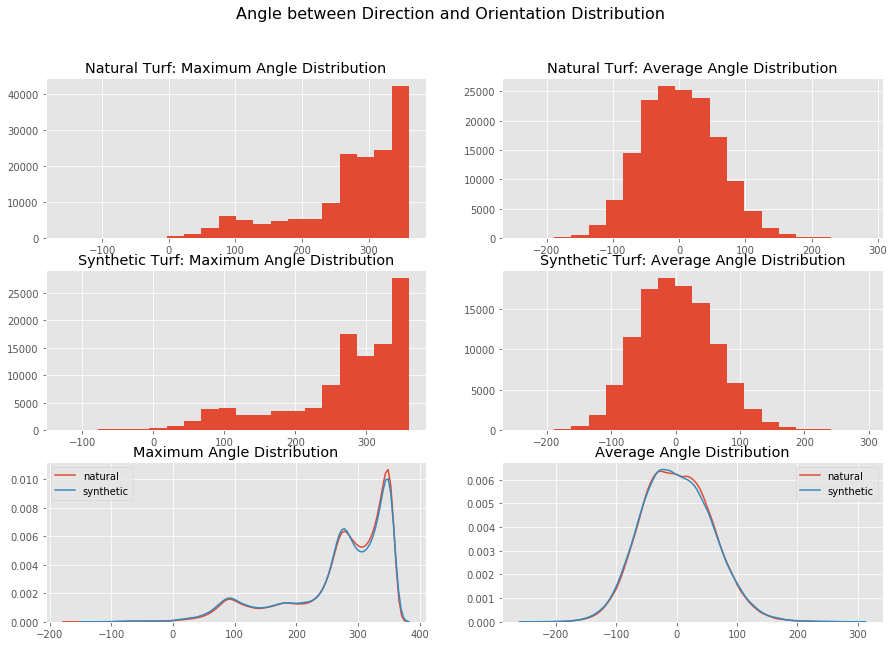

In [77]:
fig, axs = plt.subplots(3,2,figsize=(15,10))

axs[0,0].hist(motion_df[motion_df.FieldType == 'Natural'].angle_max, bins = 20)
axs[0,0].set_title('Natural Turf: Maximum Angle Distribution')

axs[1,0].hist(motion_df[motion_df.FieldType == 'Synthetic'].angle_max, bins = 20)
axs[1,0].set_title('Synthetic Turf: Maximum Angle Distribution')

axs[0,1].hist(motion_df[motion_df.FieldType =='Natural'].angle_avg, bins = 20)
axs[0,1].set_title('Natural Turf: Average Angle Distribution')

axs[1,1].hist(motion_df[motion_df.FieldType == 'Synthetic'].angle_avg, bins = 20)
axs[1,1].set_title('Synthetic Turf: Average Angle Distribution')

sns.kdeplot(motion_df[motion_df.FieldType == 'Natural'].angle_max, ax = axs[2,0], label='natural')
sns.kdeplot(motion_df[motion_df.FieldType == 'Synthetic'].angle_max,ax = axs[2,0], label='synthetic')
axs[2,0].set_title('Maximum Angle Distribution')

sns.kdeplot(motion_df[motion_df.FieldType == 'Natural'].angle_avg, ax = axs[2,1], label='natural')
sns.kdeplot(motion_df[motion_df.FieldType == 'Synthetic'].angle_avg,ax = axs[2,1], label='synthetic')
axs[2,1].set_title('Average Angle Distribution')

plt.suptitle('Angle between Direction and Orientation Distribution', fontsize=16)
plt.show()

We get identical distributions for the angle too.

It means that the type of turf does not affect the main motion features.

We didn't see any difference between the motion features on different playing surfaces in general, but maybe some differences are depending on the weather conditions or the player position?

`1` Movement under different weather conditions:

In [78]:
# clean the weather and stadium type values in the motion dataset
motion_df_cleaned = clean_play_df(motion_df)

In [79]:
def compare_distributions_weather(df, field, title=''):
    '''
    Helper function to compare the distribution of the specified field
    '''
    fig, axs = plt.subplots(4,1,figsize=(10,12))
    sns.kdeplot(df[(df.Weather == 'Cloudy') & (df.FieldType == 'Natural') & (df.StadiumType == 'Outdoor')][field].values, ax = axs[0], label='Natural')
    sns.kdeplot(df[(df.Weather == 'Cloudy') & (df.FieldType == 'Synthetic') & (df.StadiumType == 'Outdoor')][field].values, ax = axs[0], label='Synthetic')
    axs[0].set_title('Cloudy Weather')
    
    sns.kdeplot(df[(df.Weather == 'Clear') & (df.FieldType == 'Natural') & (df.StadiumType == 'Outdoor')][field].values, ax = axs[1], label='Natural')
    sns.kdeplot(df[(df.Weather == 'Clear') & (df.FieldType == 'Synthetic') & (df.StadiumType == 'Outdoor')][field].values, ax = axs[1], label='Synthetic')
    axs[1].set_title('Clear Weather')
    
    sns.kdeplot(df[(df.Weather == 'Rain') & (df.FieldType == 'Natural') & (df.StadiumType == 'Outdoor')][field].values, ax = axs[2], label='Natural')
    sns.kdeplot(df[(df.Weather == 'Rain') & (df.FieldType == 'Synthetic') & (df.StadiumType == 'Outdoor')][field].values, ax = axs[2], label='Synthetic')
    axs[2].set_title('Rainy Weather')
    
    sns.kdeplot(df[(df.Weather == 'Snow') & (df.FieldType == 'Natural') & (df.StadiumType == 'Outdoor')][field].values, ax = axs[3], label='Natural')
    sns.kdeplot(df[(df.Weather == 'Snow') & (df.FieldType == 'Synthetic') & (df.StadiumType == 'Outdoor')][field].values, ax = axs[3], label='Synthetic')
    axs[3].set_title('Snowy Weather')
    
    plt.suptitle(title, fontsize=16)
    
    plt.show()

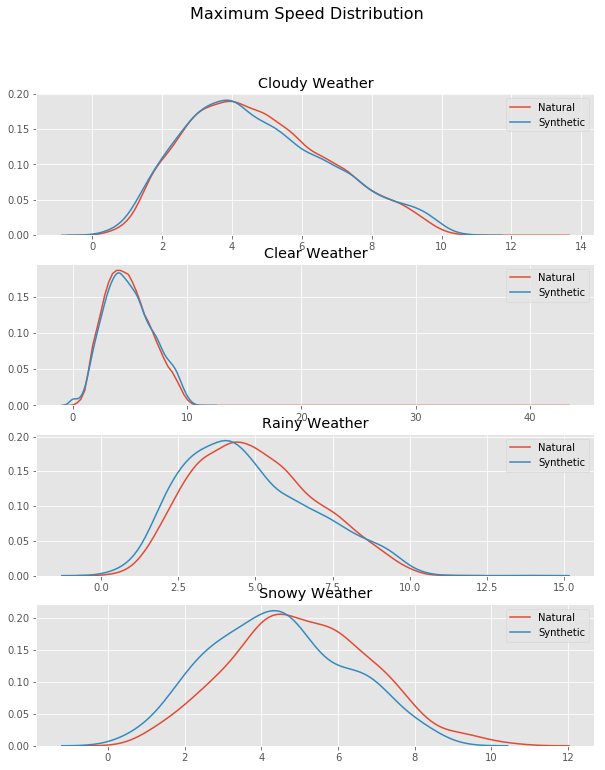

In [80]:
compare_distributions_weather(motion_df_cleaned, 's_max', 'Maximum Speed Distribution')

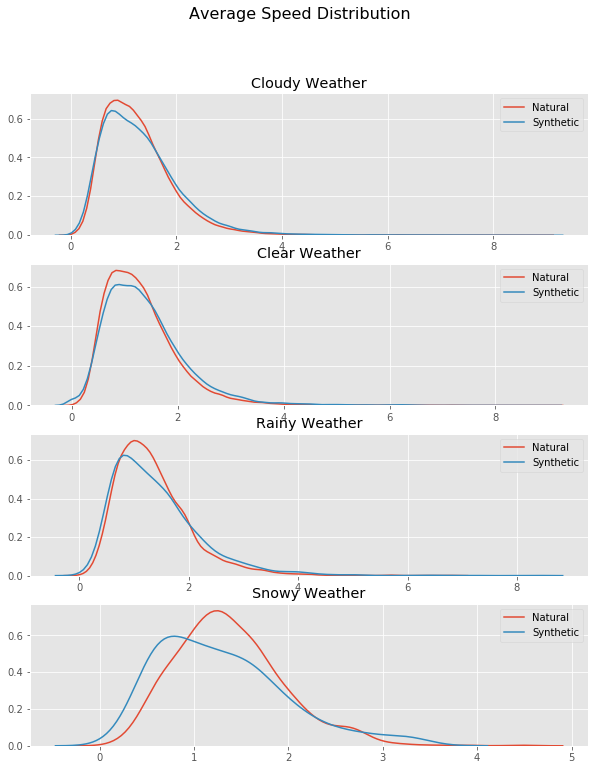

In [81]:
compare_distributions_weather(motion_df_cleaned, 's_avg', 'Average Speed Distribution')

__Observations:__
* We have a slight difference for maximum speed distributions for rainy and snowy weather (when playing on the outdoor stadium, of course).  We see that the maximum speed on synthetic turf is a bit lower.
* We can see that the average speed for the rainy and snowy weather is lower on the synthetic turf.

Kolmogorov-Smirnov test:

In [82]:
# compare the samples for rainy weather
synth_rain = motion_df_cleaned[(motion_df_cleaned.Weather == 'Rain') & (motion_df_cleaned.FieldType == 'Synthetic') & (motion_df_cleaned.StadiumType == 'Outdoor')]['s_avg'].values
nat_rain = motion_df_cleaned[(motion_df_cleaned.Weather == 'Rain') & (motion_df_cleaned.FieldType == 'Natural') & (motion_df_cleaned.StadiumType == 'Outdoor')]['s_avg'].values

D, pvalue = ss.ks_2samp(synth_rain, nat_rain)
D, pvalue

(0.048158820669151114, 1.6124376864767122e-05)

In [83]:
# compare the samples for snowy weather
synth_snow = motion_df_cleaned[(motion_df_cleaned.Weather == 'Snow') & (motion_df_cleaned.FieldType == 'Synthetic') & (motion_df_cleaned.StadiumType == 'Outdoor')]['s_avg'].values
nat_snow = motion_df_cleaned[(motion_df_cleaned.Weather == 'Snow') & (motion_df_cleaned.FieldType == 'Natural') & (motion_df_cleaned.StadiumType == 'Outdoor')]['s_avg'].values

D, pvalue = ss.ks_2samp(synth_snow, nat_snow)
D, pvalue

(0.14372733344741362, 2.157807147301668e-05)

The p-value is very small for both snowy and rainy weather. So with a certain level of confidence, we can conclude that maximum speed values for snowy and rainy weather come from different distributions. __Probably, the synthetic turf under severe weather conditions makes the players slow down.__

`2` Movement depending on a player position:

In [84]:
def compare_distributions_position(df, field, title=''):
    '''
    Helper function to compare the distribution of a specific variable for different player positions
    '''
    # get the positions
    positions = df.Position.unique()
    
    # creat subplots
    fig, axs = plt.subplots(len(positions),1,figsize=(7,25))
    
    for i, pos in enumerate(positions):
        sns.kdeplot(df[(df.Position == pos) & (df.FieldType == 'Natural')][field].values, ax = axs[i], label='Natural')
        sns.kdeplot(df[(df.Position == pos) & (df.FieldType == 'Synthetic')][field].values, ax = axs[i], label='Synthetic')
        axs[i].set_title(pos)
    
    plt.suptitle(title, fontsize=16)
    plt.show()

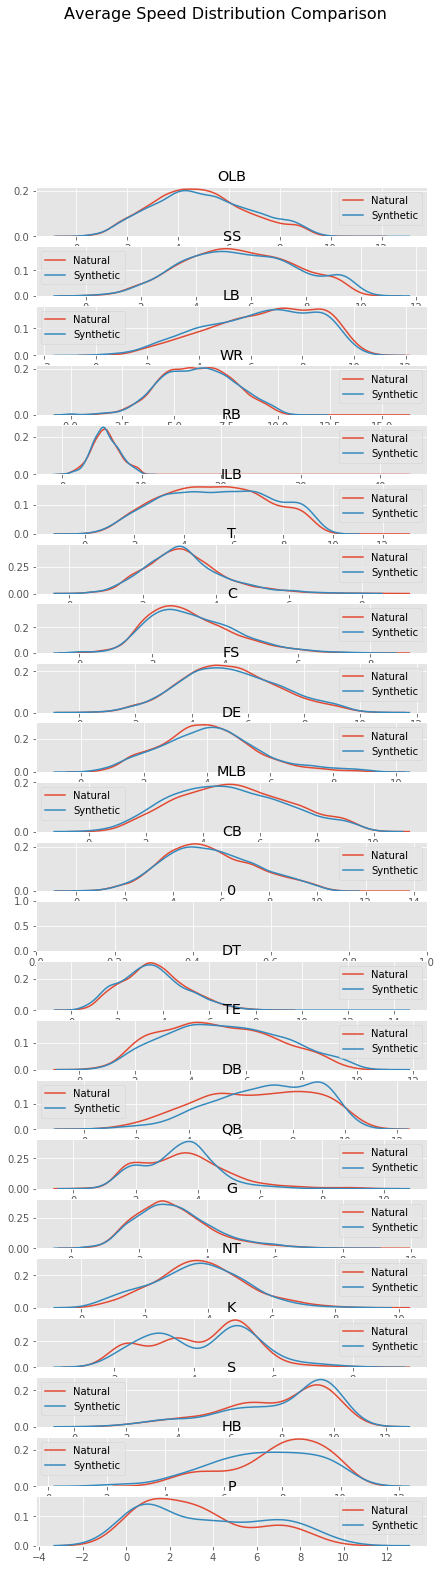

In [85]:
compare_distributions_position(motion_df_cleaned, 's_max', title='Average Speed Distribution Comparison')

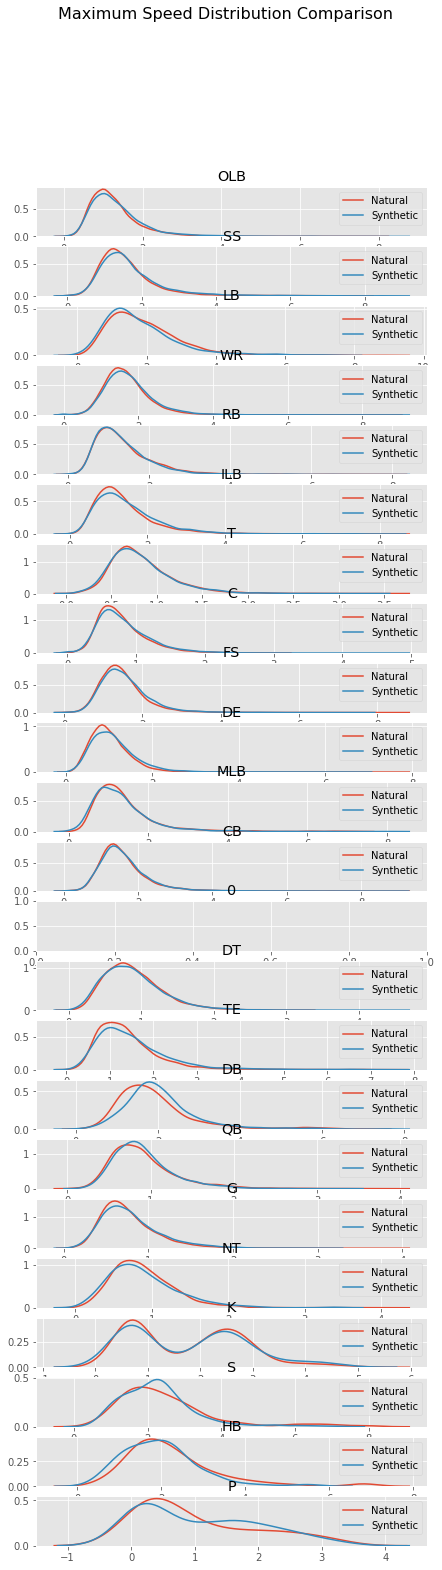

In [86]:
compare_distributions_position(motion_df_cleaned, 's_avg', title='Maximum Speed Distribution Comparison')

__Observations:__
There are some slight differences in speed distribution for DB (defensive back) and HB (halfback) player positions. Surprisingly, in both cases, the speed is more distributed towards higher values.

Let's conduct a test:

In [87]:
# compare the samples for DB
synth_DB = motion_df_cleaned[(motion_df_cleaned.Position == 'DB') & (motion_df_cleaned.FieldType == 'Synthetic')]['s_avg'].values
nat_DB = motion_df_cleaned[(motion_df_cleaned.Position == 'DB') & (motion_df_cleaned.FieldType == 'Natural')]['s_avg'].values

D, pvalue = ss.ks_2samp(synth_DB, nat_DB)
D, pvalue

(0.1465807036741293, 1.9996472256133874e-06)

In [88]:
# compare the samples for HB
synth_HB = motion_df_cleaned[(motion_df_cleaned.Position == 'HB') & (motion_df_cleaned.FieldType == 'Synthetic')]['s_avg'].values
nat_HB = motion_df_cleaned[(motion_df_cleaned.Position == 'HB') & (motion_df_cleaned.FieldType == 'Natural')]['s_avg'].values

D, pvalue = ss.ks_2samp(synth_HB, nat_HB)
D, pvalue

(0.1476846057571965, 0.1619575339281058)

The Kolmogorov-Smirnov test shows that the distribution of the average speed for the DB (defensive back) position is different for synthetic and natural turf. Probably, the players move slightly faster on the synthetic turf.

## Synthetic vs Natural Turf

Hypothesis testing proved that there is a higher risk of injury for the synthetic turf. But why? Let's try to look at different factors, such as weather, temperature, movement features.

`1` Synthetic and natural turf and the weather conditions:

In [89]:
# group by FieldType and StaduimType
grouped_df = game_injury_df.groupby(by=['FieldType', 'StadiumType']).count().reset_index()

# get the number of games on natural turf for each stadium type
natural_gr = grouped_df[grouped_df.FieldType == 'Natural'][['StadiumType','Injury']]
natural_gr = natural_gr.append({'StadiumType':'Indoor',  'Injury' : 0}, ignore_index = True).sort_values(by=['StadiumType'])

# get the number of games on synthetic turf for each stadium type
synthetic_gr = grouped_df[grouped_df.FieldType == 'Synthetic'][['StadiumType','Injury']].sort_values(by=['StadiumType'])

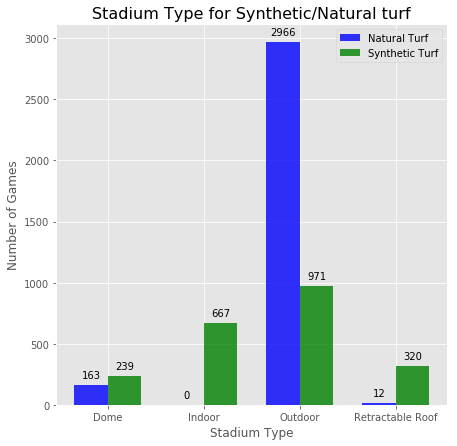

In [90]:
# visualize the stadium type for natural and synthetic turf
n_groups = len(natural_gr)
fig, ax = plt.subplots(figsize=(7,7))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, natural_gr.Injury.values, bar_width,
alpha=opacity,
color='b',
label='Natural Turf')

rects2 = plt.bar(index + bar_width, synthetic_gr.Injury.values, bar_width,
alpha=opacity,
color='g',
label='Synthetic Turf')

plt.xticks(index + bar_width/2, natural_gr.StadiumType.values)
plt.xlabel('Stadium Type')
plt.ylabel('Number of Games')
plt.legend()
plt.title('Stadium Type for Synthetic/Natural turf', fontsize=16)
add_value_labels(ax)
plt.show()

Most of the games are played outdoors. We see that there are a lot of outdoor games played on synthetic turf.

Can extreme weather conditions increase the risk of injury?

In [91]:
weather_injury_nat = game_injury_df[(game_injury_df['StadiumType'] == 'Outdoor') & (game_injury_df['FieldType'] == 'Natural')]\
.groupby(by=['Weather']).sum().reset_index().sort_values(by=['Weather'])

weather_injury_synth = game_injury_df[(game_injury_df['StadiumType'] == 'Outdoor') & (game_injury_df['FieldType'] == 'Synthetic')]\
.groupby(by=['Weather']).sum().reset_index().sort_values(by=['Weather'])

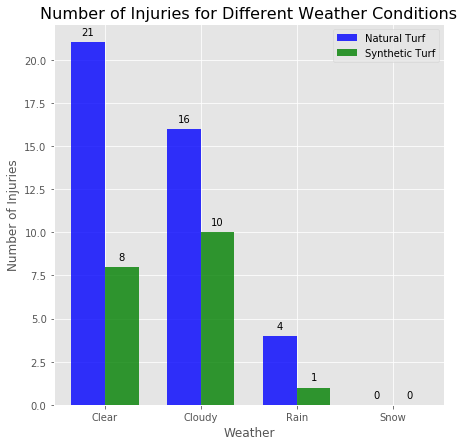

In [92]:
# visualize the staduin type for natural and synthetic turf
n_groups = len(weather_injury_synth)
fig, ax = plt.subplots(figsize=(7,7))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, weather_injury_nat.Injury.values, bar_width,
alpha=opacity,
color='b',
label='Natural Turf')

rects2 = plt.bar(index + bar_width, weather_injury_synth.Injury.values, bar_width,
alpha=opacity,
color='g',
label='Synthetic Turf')

plt.xticks(index + bar_width/2, weather_injury_synth.Weather.values)
plt.xlabel('Weather')
plt.ylabel('Number of Injuries')
plt.legend()
add_value_labels(ax)
plt.title('Number of Injuries for Different Weather Conditions', fontsize=16)
plt.show()

In [93]:
weather_injury_nat = game_injury_df[(game_injury_df['StadiumType'] == 'Outdoor') & (game_injury_df['FieldType'] == 'Natural')]\
.groupby(by=['Weather']).mean().reset_index().sort_values(by=['Weather'])

weather_injury_synth = game_injury_df[(game_injury_df['StadiumType'] == 'Outdoor') & (game_injury_df['FieldType'] == 'Synthetic')]\
.groupby(by=['Weather']).mean().reset_index().sort_values(by=['Weather'])

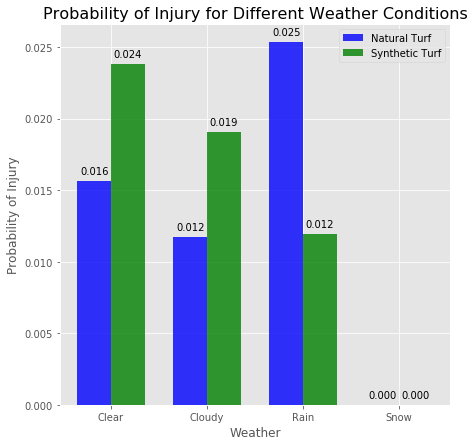

In [94]:
# visualize the staduin type for natural and synthetic turf
n_groups = len(weather_injury_synth)
fig, ax = plt.subplots(figsize=(7,7))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, weather_injury_nat.Injury.values, bar_width,
alpha=opacity,
color='b',
label='Natural Turf')

rects2 = plt.bar(index + bar_width, weather_injury_synth.Injury.values, bar_width,
alpha=opacity,
color='g',
label='Synthetic Turf')

plt.xticks(index + bar_width/2, weather_injury_synth.Weather.values)
plt.xlabel('Weather')
plt.ylabel('Probability of Injury')
plt.legend()
plt.title('Probability of Injury for Different Weather Conditions', fontsize=16)
add_value_labels(ax, decimals = 3)
plt.show()

The highest probability of injury is:
* for rainy weather on natural turf;
* sunny weather on synthetic turf.

So there are two questions here:
1. Could the natural turf be more slippery when it is raining? Do we have a higher chance of injury on rainy days for natural turf?
2. Is synthetic turf more dangerous on sunny days? Does the high temperature also raise chances of injury on synthetic turf?

Do some hypothesis testing to prove that the risk of injury on natural turf on rainy days is higher. The null hypothesis states that the probability of injury on natural turf on rainy days is lower or equal than the injury probability when those conditions are not met.

In [95]:
# get number of trials and overall injury rate under null
hyp_df = game_injury_df[['StadiumType', 'FieldType', 'Weather', 'Injury']][game_injury_df['StadiumType'] == 'Outdoor']

n_other = len(hyp_df[(hyp_df.FieldType != 'Natural') & (hyp_df.Weather != 'Rain')])

n_natural_rain = len(hyp_df[(hyp_df.FieldType == 'Natural') & (hyp_df.Weather == 'Rain')])

p_null = len(hyp_df[(hyp_df.FieldType != 'Natural') & (hyp_df.Weather != 'Rain')]) / len(hyp_df)

p_injury_1 = hyp_df[(hyp_df.FieldType == 'Natural') & (hyp_df.Weather == 'Rain')].Injury.mean()
p_injury_0 = hyp_df[(hyp_df.FieldType != 'Natural') & (hyp_df.Weather != 'Rain')].Injury.mean()

# compute standard error
se_p = np.sqrt(p_null * (1-p_null) * (1/n_other + 1/n_natural_rain))

#  compute z-score and p-value
z = (p_injury_1 - p_injury_0) / se_p

print('The z-score is: {}'.format(z))
print('The p-value is: {}'.format(1-ss.norm.cdf(z)))

The z-score is: 0.10799355288655726
The p-value is: 0.4570004031759113


P-value is too high, and we can't reject the null hypothesis. There is no statistical significance that natural turf is riskier on rainy weather.

Now let's try to look at the synthetic turf at high temperatures and clear weather.

In [96]:
# get the distribution for temperature for plays associated with the injury on synthetic turf
temp = game_injury_df[(game_injury_df.StadiumType == 'Outdoor') & (game_injury_df.FieldType == 'Synthetic')& (game_injury_df.Injury == 1)]\
.Temperature.values

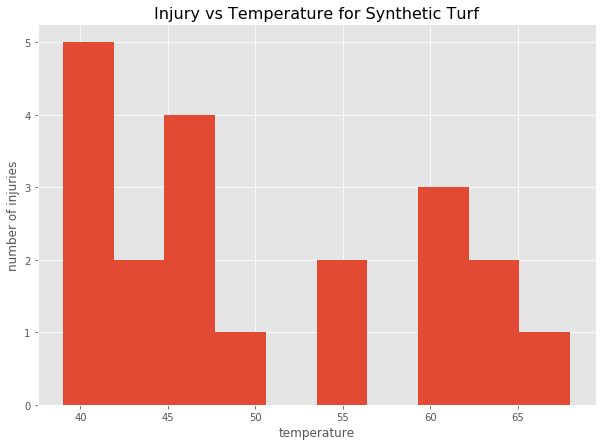

In [97]:
# plot the temperature distribution for injury on synthetic turf
plt.figure(figsize=(10,7))
plt.title('Injury vs Temperature for Synthetic Turf', fontsize=16)
plt.xlabel('temperature')
plt.ylabel('number of injuries')
plt.hist(temp)
plt.show()

I can't see any significant spike for the number of injuries for high temperatures. I don't think that extremely high temperatures can cause a higher risk of injury. On the contrary, we see that there are more injuries at lower temperatures.

Let's try hypothesis testing to prove that there are higher chances of injury on sunny days and synthetic turf:

In [98]:
n_other = len(hyp_df[(hyp_df.FieldType != 'Synthetic') & (hyp_df.Weather != 'Clear')])
n_synth_clear = len(hyp_df[(hyp_df.FieldType == 'Synthetic') & (hyp_df.Weather == 'Clear')])

p_null = len(hyp_df[(hyp_df.FieldType != 'Synthetic') & (hyp_df.Weather != 'Clear')]) / len(hyp_df)

p_injury_1 = hyp_df[(hyp_df.FieldType == 'Synthetic') & (hyp_df.Weather == 'Clear')].Injury.mean()
p_injury_0 = hyp_df[(hyp_df.FieldType != 'Synthetic') & (hyp_df.Weather != 'Clear')].Injury.mean()

# compute standard error
se_p = np.sqrt(p_null * (1-p_null) * (1/n_other + 1/n_synth_clear))

#  compute z-score and p-value
z = (p_injury_1 - p_injury_0) / se_p

print('The z-score is: {}'.format(z))
print('The p-value is: {}'.format(1-ss.norm.cdf(z)))

The z-score is: 0.3269714097114601
The p-value is: 0.37184475473771617


The p-value is too high. We can't reject the null hypothesis.

My analysis shows that weather conditions interacting with field types don't lead to a higher risk of injury. 

`2` Synthetic and natural turf and player positions:

Let's plot the probability of injury on synthetic turf for different player positions:

In [99]:
# get the probabilities of injury for different player positions

# natural turf
pos_injury_nat = play_injury_df[(play_injury_df['FieldType'] == 'Natural')]\
.groupby(by=['Position']).mean().reset_index().sort_values(by=['Position'])

# synthetic turf
pos_injury_synth = play_injury_df[(play_injury_df['FieldType'] == 'Synthetic')]\
.groupby(by=['Position']).mean().reset_index().sort_values(by=['Position'])

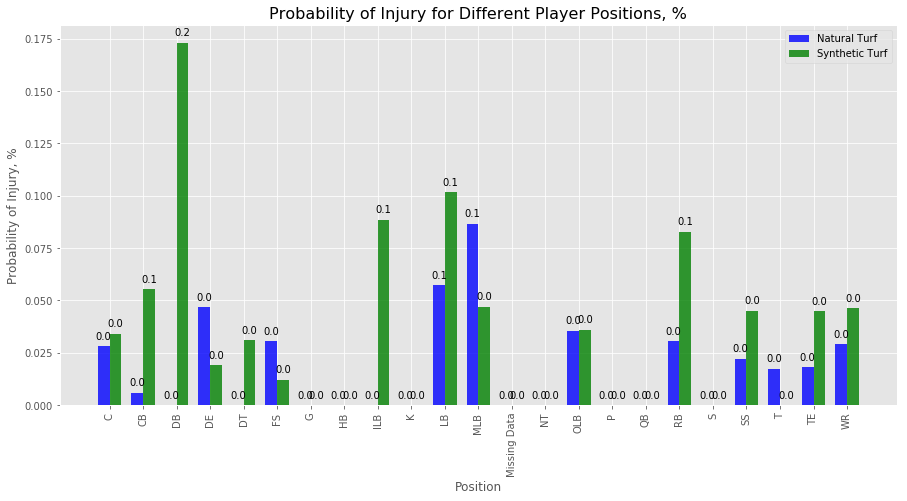

In [100]:
n_groups = len(pos_injury_nat)
fig, ax = plt.subplots(figsize=(15,7))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, pos_injury_nat.Injury.values*100, bar_width,
alpha=opacity,
color='b',
label='Natural Turf')

rects2 = plt.bar(index + bar_width, pos_injury_synth.Injury.values*100, bar_width,
alpha=opacity,
color='g',
label='Synthetic Turf')

plt.xticks(index + bar_width/2, pos_injury_synth.Position.values, rotation=90)
plt.xlabel('Position')
plt.ylabel('Probability of Injury, %')
plt.legend()
plt.title('Probability of Injury for Different Player Positions, %', fontsize=16)
add_value_labels(ax, decimals = 1)
plt.show()

It looks like players in DB (defensive back) position have higher chances of injury on synthetic turf!

Let's do some hypothesis testing to prove that there are higher chances of injury for DB players on synthetic turf:

In [101]:
hyp_df = play_injury_df[['FieldType', 'Position', 'Injury']]

n_other = len(hyp_df[(hyp_df.FieldType != 'Synthetic') & (hyp_df.Position != 'DB')])
n_synth_db = len(hyp_df[(hyp_df.FieldType == 'Synthetic') & (hyp_df.Position == 'DB')])

p_null = len(hyp_df[(hyp_df.FieldType != 'Synthetic') & (hyp_df.Position != 'DB')]) / len(hyp_df)

p_injury_1 = hyp_df[(hyp_df.FieldType == 'Synthetic') & (hyp_df.Position == 'DB')].Injury.mean()
p_injury_0 = hyp_df[(hyp_df.FieldType != 'Synthetic') & (hyp_df.Position != 'DB')].Injury.mean()

# compute standard error
se_p = np.sqrt(p_null * (1-p_null) * (1/n_other + 1/n_synth_db))

#  compute z-score and p-value
z = (p_injury_1 - p_injury_0) / se_p

print('The z-score is: {}'.format(z))
print('The p-value is: {}'.format(1-ss.norm.cdf(z)))

The z-score is: 0.07303732805126828
The p-value is: 0.4708882066646536


Unfortunately, we can't reject the null hypothesis.

But let's look at the motion features for the DB position and compare them for different field types.

In [102]:
db_motion = motion_df_cleaned[motion_df_cleaned.Position == 'DB']

In [103]:
def compare_distributions(db_motion, field1, field2, title=''):
    fig, axs = plt.subplots(3,2,figsize=(15,10), sharex=True)

    axs[0,0].hist(db_motion[db_motion.FieldType == 'Natural'][field1], bins = 20)
    axs[0,0].set_title('Natural: {}'.format(field1))

    axs[1,0].hist(db_motion[db_motion.FieldType == 'Synthetic'][field1], bins = 20)
    axs[1,0].set_title('Synthetic: {}'.format(field1))

    axs[0,1].hist(db_motion[db_motion.FieldType == 'Natural'][field2], bins = 20)
    axs[0,1].set_title('Natural: {}'.format(field2))

    axs[1,1].hist(db_motion[db_motion.FieldType == 'Synthetic'][field2], bins = 20)
    axs[1,1].set_title('Synthetic: {}'.format(field2))

    sns.kdeplot(db_motion[db_motion.FieldType == 'Natural'][field1], ax = axs[2,0], label='natural')
    sns.kdeplot(db_motion[db_motion.FieldType == 'Synthetic'][field1],ax = axs[2,0], label='synthetic')
    axs[2,0].set_title('{} Distribution'.format(field1))

    sns.kdeplot(db_motion[db_motion.FieldType == 'Natural'][field2], ax = axs[2,1], label='natural')
    sns.kdeplot(db_motion[db_motion.FieldType == 'Synthetic'][field2],ax = axs[2,1], label='synthetic')
    axs[2,1].set_title('{} Distribution'.format(field2))

    plt.suptitle(title, fontsize=16)
    plt.show()

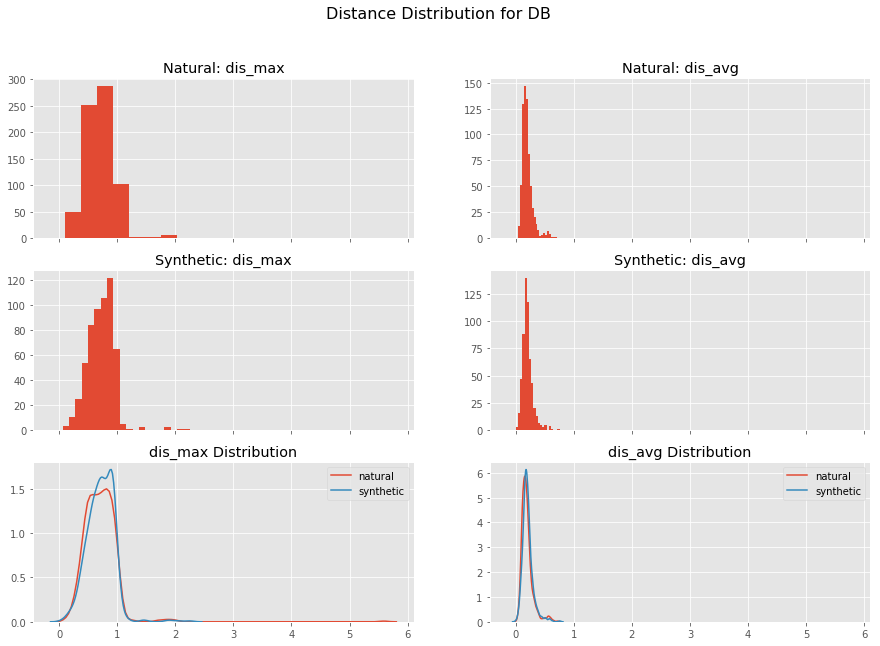

In [104]:
compare_distributions(db_motion, 'dis_max', 'dis_avg', title='Distance Distribution for DB')

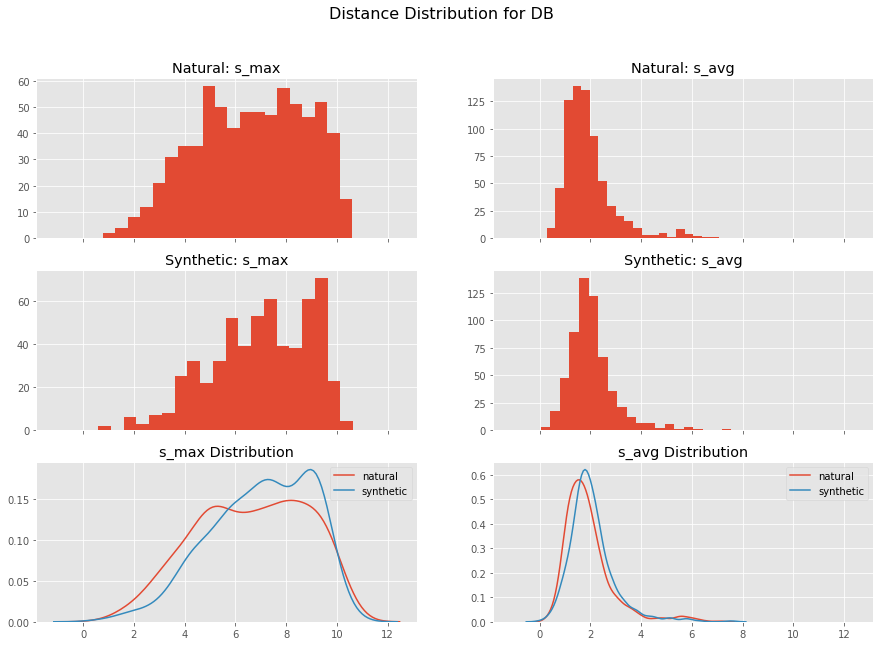

In [105]:
compare_distributions(db_motion, 's_max', 's_avg', title='Distance Distribution for DB')

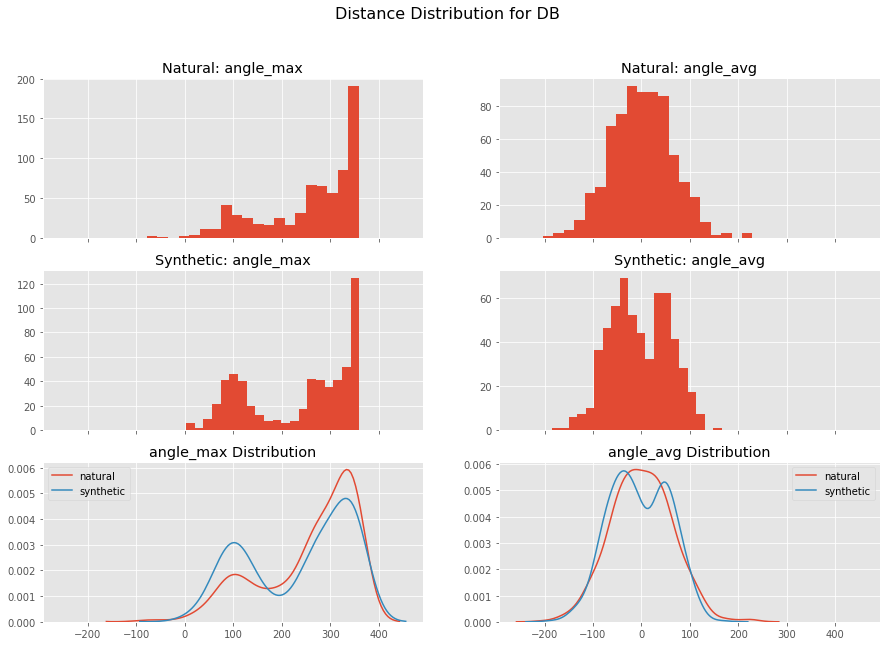

In [106]:
compare_distributions(db_motion, 'angle_max', 'angle_avg', title='Distance Distribution for DB')

When we look at player movement in the defensive back position we see:
* The distributions for distances traveled are almost the same for natural and synthetic turf;
* The angle and speed distributions for the synthetic and natural turf fields are slightly different. A higher speed spike for synthetic turf is especially interesting. 

Let's look at the injury on synthetic turf and DB player position:

In [107]:
db_motion[db_motion.Injury == 1][['RosterPosition', 'StadiumType', 'FieldType','PlayType', 'Position',
       'PositionGroup', 'time_max', 'dir_max', 'dis_max', 'o_max', 's_max',
       'angle_max', 'time_avg', 'dir_avg', 'dis_avg', 'o_avg', 's_avg',
       'angle_avg', 'Injury']]

RosterPosition StadiumType  FieldType              PlayType Position  \
104         Safety      Indoor  Synthetic  Kickoff Not Returned       DB   

    PositionGroup  time_max  dir_max  dis_max   o_max  s_max  angle_max  \
104            DB      19.3    357.9     1.02  321.46  10.11     282.26   

     time_avg     dir_avg   dis_avg       o_avg     s_avg  angle_avg  Injury  
104      9.65  240.235567  0.359691  252.408969  3.588093  12.173402     1.0

We have only one injury record for DB position on synthetic turf, and we see that the maximum speed is `10.11`, which is quite high! And as we noticed, players in the DB position tend to have higher speed on synthetic turf. __Possibly, higher speeds on synthetic turf could lead to an elevated risk of injury.__

Let's look at players in the ILB (Inside linebackers) position:

In [108]:
db_motion = motion_df_cleaned[motion_df_cleaned.Position == 'ILB']

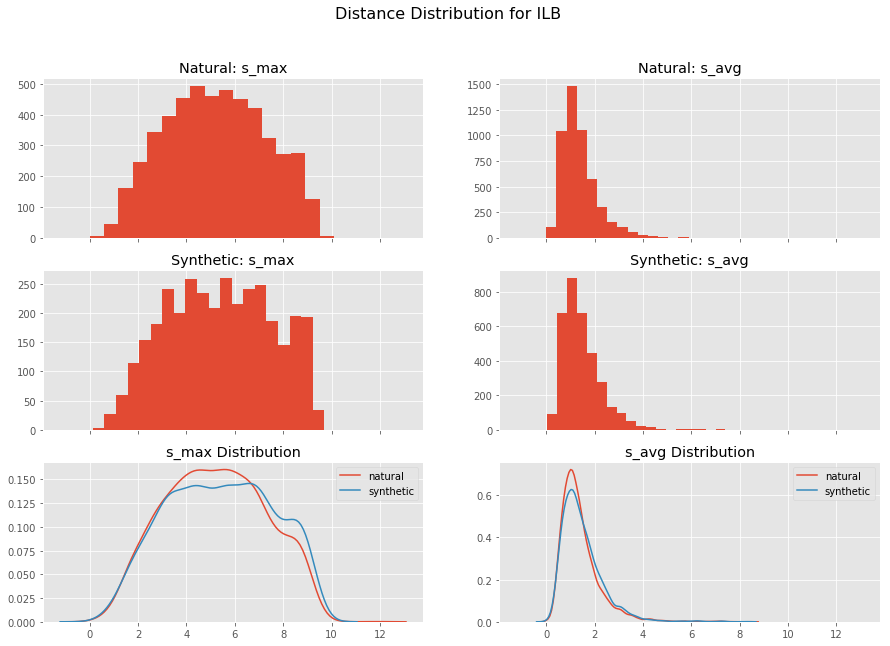

In [109]:
compare_distributions(db_motion, 's_max', 's_avg', title='Distance Distribution for ILB')

The distributions for speed for ILB position are almost identical. But we still see a little spike for high speeds for synthetic turf.

Let's look closely at the injury records:

In [110]:
db_motion[db_motion.Injury == 1][['RosterPosition', 'StadiumType', 'FieldType','PlayType', 'Position',
       'PositionGroup', 'time_max', 'dir_max', 'dis_max', 'o_max', 's_max',
       'angle_max', 'time_avg', 'dir_avg', 'dis_avg', 'o_avg', 's_avg',
       'angle_avg', 'Injury']]

RosterPosition StadiumType  FieldType PlayType Position PositionGroup  \
8      Linebacker      Indoor  Synthetic     Rush      ILB            LB   
32     Linebacker     Outdoor  Synthetic     Punt      ILB            LB   
90     Linebacker      Indoor  Synthetic     Pass      ILB            LB   

    time_max  dir_max  dis_max   o_max  s_max  angle_max  time_avg  \
8       21.2   359.44     0.53  357.09   2.39     326.17     10.60   
32     106.5   358.73     0.94  359.91   9.20     358.59     53.25   
90      26.5   357.29     0.64  355.37   6.38      85.90     13.25   

       dir_avg   dis_avg       o_avg     s_avg  angle_avg  Injury  
8   125.553991  0.056103   68.076291  0.469531 -57.477700     1.0  
32  208.129662  0.075629  152.852899  0.693668 -55.276764     1.0  
90  206.976729  0.140075  153.471015  1.384737 -53.505714     1.0

Here we can see that only one of three injury records corresponds to the high speed of `9.20`.

## Conclusions:
* There is a higher risk of injury when playing on the synthetic turf
* Under severe weather conditions (rain or snow) players on the synthetic turf tend to have a lower speed than the players on natural turf
* Probably, the synthetic turf can't sustain the high speed. It makes the players slow down when the weather is bad. Probably, moving too fast on synthetic turf could even raise the risk of injury when playing in a certain position

## References and Credits
1. [Great Medium article](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9) on correlation for categorical variables. I highly encourage to read it!
2. [dython library](https://github.com/shakedzy/dython/blob/master/dython/nominal.py): The implementation of Theil's U

__I will further update this notebook, so, please, feel free to ask questions and add comments!__